Проект 6. Выбираем авто выгодно
===

**1. Постановка задачи и первичное знакомство с данными**
---

***1.1. Постановка задачи***

Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

В качестве исходных данных предлагается датасет, который будет использоваться для проверки качества работы модели в соревнованиях Kaggle. Аналогичные данные для обучения модели предполагается собрать из открытых публичных источников с помощью парсинга или используя другие готовые датасеты. В качестве метрики для оценки качества модели предполагается использовать средний абсолютный процент ошибки *MAPE*.
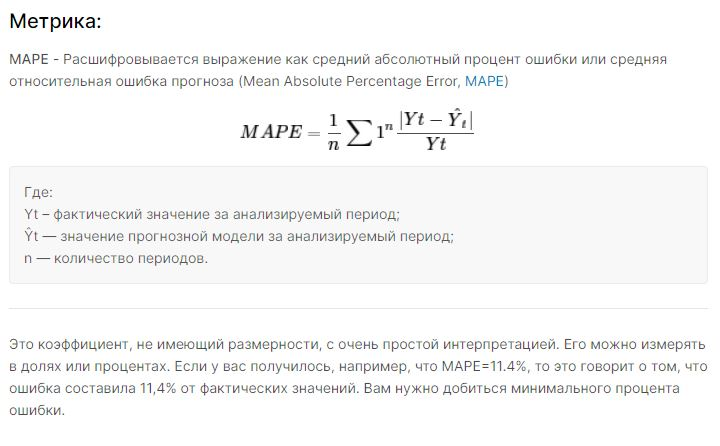

Разрешено использовать любые ML алгоритмы и библиотеки, кроме DL. Необходимо, по возможности, получить реальный ML продукт, который сможет потом работать на новых данных.

***1.2. Подключение требуемых библиотек, инициализация требуемых переменных, процедур и функций***

In [1]:
import numpy as np
import pandas as pd

import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

import sys

from sklearn.preprocessing import LabelEncoder, StandardScaler 
import category_encoders as ce

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from tqdm.notebook import tqdm

In [2]:
# Анализ используемых версий среды и отдельных библиотек
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


In [3]:
# Фиксируем версии пакетов
!pip freeze > requirements.txt

In [4]:
# Фиксируем RANDOM_SEED,для воспроизводимости расчетов
RANDOM_SEED = 42
# Подключаем к ноутбуку внешние датасеты
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
# Размер валидационной части датасета
VAL_SIZE   = 0.20   # 20%

In [5]:
# Списки для хранения названия признаков по типам
num_cols = [] # Числовые
cat_cols = [] # Категориальные
bin_cols = [] # Бинарные
serv_cols = [] # Служебные

In [6]:
# Функции обработки значений признаков
def process_bodyType(val):
    """Процедура для унификации значений признака bodyType

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    val = str(val)
    res = val.find('дв.')
    if res == -1:
        val = val.split(' ')[0]
    else:
        val = val[:res+3]
    return val

def process_color(val):
    """Процедура для унификации значений признака color

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    dic = {'040001':'чёрный', 'FAFBFB':'белый', 'CACECB':'серебристый', '97948F':'серый',
           '0000CC':'синий', 'EE1D19':'красный', '200204':'коричневый', '007F00':'зелёный',
           'C49648':'бежевый', '22A0F8':'голубой', 'DEA522':'золотистый', '660099':'пурпурный',
           'FFD600':'желтый', '4A2197':'фиолетовый', 'FF8649':'оранжевый', 'FFC0CB':'розовый'
          }
    return dic.get(val, np.nan)

def process_vehicleTransmission(val):
    """Процедура для преобразования значений признака vehicleTransmission

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    dic = {'AUTOMATIC':'автоматическая', 'MECHANICAL':'механическая',
           'VARIATOR':'вариатор', 'ROBOT':'роботизированная'}
    return dic.get(val, np.nan)

def process_wheel(val):
    """Процедура для преобразования значений признака Руль

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    dic = {'LEFT':'Левый', 'RIGHT':'Правый'}
    return dic.get(val, np.nan)


def process_vp(val):
    """Процедура для преобразования значений признака ПТС

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    dic = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}
    return dic.get(val, np.nan)

def process_ownership_test(val):
    """Процедура для преобразования значений признака Владение из тествого датасета

    Args:
        val (string): Значение признака для обработки
        
   Returns:
        string: Обработанное значение признака
    """
    if isinstance(val, str):
        lst = val.split(' ')
        if len(lst) == 2:
            if lst[1][0] == 'г' or lst[1][0] == 'л':
                return int(lst[0]) * 12
            elif lst[1][0] == 'м':
                return int(lst[0])
        elif len(lst) == 5:
            res = 0;
            if lst[1][0] == 'г' or lst[1][0] == 'л':
                res += int(lst[0]) * 12
            if  lst[4][0] == 'м':
                res += int(lst[3])
            if res > 0:
                return res
    else:
        return np.nan
    
def process_ownership_train1(row):
    """Процедура для преобразования значений признака ВладениеНачало из тренировочного датасета

    Args:
        row (row): Строка признаков из тренировочного датасета
        
   Returns:
        int: Обработанное значение признака (в месяцах)
    """
    val = row['ВладениеНачало']
    
    if val == 0:
        return 0
    else:
        year = int(val[9:13])
        if val[25] == '}':
            mounth = int(val[24:25])
        else:
            mounth = int(val[24:26])
        return year * 12 + mounth

def process_ownership_train2(row):
    """Процедура для преобразования значений признака Владение из тренировочного датасета

    Args:
        row (row): Строка признаков из тренировочного датасета
        
   Returns:
        int: Обработанное значение признака (в месяцах)
    """
    if row['ВладениеНачало'] == 0:
        return 0
    else:
        res = row['ВладениеКонец'] - row['ВладениеНачало']
        return 0 if res < 0 else res

def number_graph(data, column, title):
    """Процедура для формирования типовых графиков для числовых признаков

    Args:
        data (DataFrame): датафрейм с данными
        column (string): Наименованеие колонки для визуализации
        title (string): Заголовок графика
        
   Returns:
        None
    """
    fig = plt.figure(figsize=(14,5))    
    bins = 150
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=column, bins=bins).set(title=title+' (histogram)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=column, data=data).set(title=title+' (boxplot)')
    plt.show()
    
def mape(y_true, y_pred):
    """Процедура для вычисления используемой метрики оценки качества

    Args:
        y_true (np.float64): Истенное значение целевого признака
        y_pred (np.float64): Предсказанное значение целевого признака
        
   Returns:
        np.float64: MAPE
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))


def test_regressor_mape(reg, X_train, y_train, y_test, log=False):
    """Процедура для вывода метрики оценки качества различных моделей

    Args:
        reg (string): Название модели (регрессора)
        X_train (np.float64): Признаки тренировочного датасета
        y_train (np.float64): Целевой признак тренировочного датасета
        y_test (np.float64): Целевой признак тестового датасета
        
   Returns:
        None
    """
    # Исключение для регрессора без random_state 
    if reg == 'KNeighborsRegressor':
        model = eval(reg)()
    else:
        model = eval(reg)(random_state=RANDOM_SEED)
    #print(model)    
    # Логарифмируем таргет, если необходимо
    if log == True:
        model.fit(X_train, np.log(y_train))
        predict = np.exp(model.predict(X_test))
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
    
    print(f"Точность модели {reg} по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")


***1.3. Первичное знакомство с тестовыми данными.  Описание структуры данных***

Для ознакомления со структорой данных, загрузим предолженный датасет *test.csv* и ознакомимся с его содержимым.

In [7]:
test = pd.read_csv(DIR_TEST+'test.csv')
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Исходя из полученных данных, получаем следующую интерпретацию структуры данных, представлющую собой описательные характеристики автомобиля:
-	0.	*bodyType* - тип кузова
-	1.	*brand* - фирма-производитель (бренд)
-	2.	*car_url* - ссылка на страницу на *auto.ru*
-	3.	*color* - цвет
-	4.	*complectation_dict* - словарь комплектации
-	5.	*description* - общее описание
-	6.	*engineDisplacement* - объем двигателя
-	7.	*enginePower* - мощность двигателя
-	8.	*equipment_dict* - словарь дполнительного оборудования
-	9.	*fuelType* - тип топлива
-	10.	*image* - изображение автомобиля на *auto.ru*
-	11.	*mileage* - пробег
-	12.	*modelDate* - год начала выпуска модели
-	13.	*model_info* - словарь данных по наименованию модели
-	14.	*model_name* - наименование модели
-	15.	*name* - сводные характеристики модели
-	16.	*numberOfDoors* - количество дверей
-	17.	*parsing_unixtime* - дата проведения парсинга
-	18.	*priceCurrency* - используемая валюта цены
-	19.	*productionDate* - год выпуска конкретного автомобиля
-	20.	*sell_id* - ID продавца
-	21.	*super_gen* - словарь данных по характеристикам модели
-	22.	*vehicleConfiguration* - сводная конфигурация
-	23.	*vehicleTransmission* - используемая трансмиссия
-	24.	*vendor* - регион фирмы-производителя
-	25.	*Владельцы* - количество владельцев
-	26.	*Владение* - срок последнего владения
-	27.	*ПТС* - тип ПТС
-	28.	*Привод* - тип привода
-	29.	*Руль* - тип рулевого управления
-	30.	*Состояние* - состояние автомобиля с позиции ремонта
-	31.	*Таможня* - таможенное сосотяние автомобиля

Так же, загрузим данные из файла *sample_submission.csv* для ознкомления с его структурой и содержимым.

In [9]:
submission = pd.read_csv(DIR_TEST+'sample_submission.csv')
submission.head()

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0


In [10]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


Как видно из приденных выше результатов, стуктура данных имеет следующие признаки:
- *sell_id* - ID продавца
- *price* - цена автомобиля, предлагаемого соответствующим продавцом

Признак *sell_id* является связующим для получения данных по автомобилю из датасета *test.csv*. Расмотрим более детально содержимое признака *price*:

In [11]:
submission['price'].describe()

count   34686.00
mean        0.00
std         0.00
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         0.00
Name: price, dtype: float64

Видно, что данный признак имеет нулевое значение для каждой строки. Это закономерно, с учетом того, что файл *sample_submission.csv* заявлен как образец. Получение значений данного признака для каждой строки этого файла является целевой задачей данного проекта.

**1.4. Выводы по разделу**
1. Сформулирована постановка задачи проекта и получены исходные условия и данные для его выполнения.
2. Определен типовой набор характеристик автомобиля, на базе которых требуется создать ML-модель по данному проекту.
3. По результатам первичного ознакомления с данными, делается вывод, что для использования данных в модели потребуется проведение процедуры предобработки данных.
4. Определена структура результирующих даных для использования в соревнованиях Kaggle.

**2. Сбор тренировочных данных**
---

***2.1. Анализ способов получения данных***

Для получения тренировочных данных в задании проекта рекомендуестя собрать данные из открытых публичных источников любым доступным образом. Из известных способов получения данных, определенных выше в п.1.3 можно выделить следующие:
1. Получение готовых датасетов с нужными даннными от внешних источников.
2. Получение данных парсингом сайтов.
3. Получение данных через специализированные веб-сервисы.
4. Получение данных через специализированные API.

Рассмотрим возможность использования каждого их этих источников отдельно.

***2.2. Использование готовых датасетов***

В качестве возможного решения по данному вопросу можно рассматривать получение нужных данных прямым заказом этих данных группе поддержки сайта *auto.ru*, на основе которого собраны исходные тестовые данные. Но данный запрос будет требовать коммерческих расходов, которые не предусмотрены данным проектом. Аналогичная ситуация получается и с другими автосайтами по продаже автомобилей.

Из других источников данных с готовыми датасетами, можно рассмотреть данные предлагаемые в *baseline* к выполняемому проекту. В *baseline* к соревнованию на Kaggle упоминается датасет *all_auto_ru_09_09_2020.csv*, который доступен для использования. Будем считать его возможным кандидатом для использования в качестве тренировочных данных. 

***2.3. Получение данных парсингом сайтов***

В подробном описании задания выполняемого проекта, в качесте инструментария предлагается использовать бибиотеки *requests, BeautifulSoup, selenium, scrapy* для парсинга данных непосредственно с автосайтов, предоставляющие нужные данные. Но прежде чем производить технические операциии по данному решению, необходимо провести логический анализ текущей экономической и геополитической обстановки. Дата формирования файла тестовго датасета - октябрь 2020 года. На момент реализации данного проекта - начало мая 2022 г. в мире произошли два больших события, которые кардинально повлияли на изменение стоимости автомобилей как на первичном, так и на вторичном рынке.
1. *Пандемия COVID-19*, официально начавшаяся в марте 2020 года, привела остановкам производства и нарушению логистических цепочек поставок материалов и комплектующих у автопроизводителей, что в свою очередь привело к перебоям с выпуском новых автомобилей и повышению их стоимости. В частности, автопроизводители до сих пор испытывают проблемы с чипами к автомобильной электронике. Это также привело к увеличению стоимости автомобилей на вторичном рынке.
2. *Специальная военная операция РФ на Украине* (с конца февраля 2022 г.), привела к наложению на РФ серьезных экономических санкций, а так же к глобальному нарушению устоявшейся системы мироустройства. Это, в свою очередь, привело к нарушению налаженных ранее каналов производства и обеспечения материалами/комплектующими автопроизводителей. Кроме этого серьезно измененилась взаимосвязь рубля и доллара. Многие автомобильные бренды ушли с рынка России, стоимость новых автомобилий зачастую опрелеяется непосредственно перед продажей. Вторичный рынок автомобилей снова вырос как в количестве, так и в цене.

В настоящее время, ни одно из этих событий не является завершенным и продолжает так или иначе оказывать влияние на ценообразование автомобилей.

Для использования ценовых данных по автомобилям по состоянию на май 2022 г. для обучения ML-модели, которая будет проверяться по данным, собранным в октябре 2020 г., требуется внесение различных поправочных коэффициентов цены. Получение этих коэффициентов с учетом вышесказанных событий и образования в связи с этим множества сложно взаимодействующих динамических факторов, практически представлет собой тему отдельного проекта. Таким образом, получение данных обсуждемым в данном разделе способом - *парсинг текущих данных с сайтов* - в данном проекте рассматриваться не будет.

***2.4. Получение данных через специализированные веб-сервисы***

Как уже упониналось ранее, основным источником сбора тестовых данных, на основе которых будет проверяться создаваемая ML-модель, свяляется сайт *auto.ru*. На данном ресурсе существует бесплатный сервис для оценки стоимости автомобиля (https://auto.ru/cars/evaluation/), который может так же выступать как источник получения нужной информации по ценам автомобилей. Использование данного сервиса для решения поставленной задачи возможно с помощью использования библиотеки автоматизации работы с браузером *selenium*. Но как и в случае, описанном в п.2.3, из-за сложности согласования полученных текущих данных по ценам автомобилей с ценами в тестовом датасете Kaggle от 2020 г. такой вариант сбора данных использоваться не будет. Аналогичная ситуация получается и с веб-сервисами других сайтов автопродавцов.

***2.5. Получение данных через специализированные API***

По доступной на текущей момент информации, полноценного специализированного API у сайта *auto.ru* нет. Есть предложения API для этого ресурса от стронних разработчиков, но они являются узкоспециализированными коммерческими решениями и, зачастую не  актуальны. Это связано с тем, что владельцы ресурса *auto.ru* ведут регулярную доработку своего сайта на предмет ограничения к нему доступа различными автоматическими средствами сбора информации (ботами, парсерами и т.п.). В частности, именно по этой причине предложенные в инструментарии проекта библиотеки requests и BeautifulSoup на текущий момент выдают не корректную инфоррмацию при парсинге. Исходя из этого отказываемся и от данного варианта сбора тренировочных данных.

**2.6. Вывод по разделу**

На основе проведенного анализа, единственным оперативно доступным из описанных выше методов сбора данных для тренировочного датасета  является использование готового датаесета *all_auto_ru_09_09_2020.csv*, описанного в п.2.2. Заявленная дата сбора данных в нем достаточна близка к дате тестового датасета и не требует введения дополнительных коэффициентов, для учета временной разности получения ценовых характеристик автомобилей в тренировочном и тестовом датасетах, которые требуются для данных полученных методами п.2.3 - 2.5. Так же в данном случае, не требуется финансовые расходы на получение этих данных или обход ограничений владельцев этих данных.

**3. Анализ данных и их предобработка**
---

***3.1. Знакомство с тренировочными данными.  Описание структуры данных***

Для ознакомления со структорой данных, загрузим тренировочный датасет *all_auto_ru_09_09_2020.csv* и ознакомимся с его содержимым.

In [12]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.00,2.8 MT (174 л.с.) 4WD,4.00,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.00,ORIGINAL,True,NaN,200000.00,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.00,1.8 MT (90 л.с.),4.00,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.00,ORIGINAL,True,NaN,60000.00,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.00,2.3 MT (136 л.с.) 4WD,5.00,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.00,ORIGINAL,True,NaN,99000.00,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.00,1.8 MT (90 л.с.),4.00,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.00,ORIGINAL,True,NaN,65000.00,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.00,2.0 MT (101 л.с.),4.00,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.00,DUPLICATE,True,NaN,100000.00,2020-09-08T09:22:07Z,NaN,100


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

Как видно из структуры тренировочных данных, наименования большинства признаков совпадают с данными и тестового датасета (см. п.1.3), что позволяет предположить, что это однотипные данные. Но данное утверждение требует проверки. 
Т.к. перед подготовкой данных потребуется слияние тестового и тренировочного датасетов, то проведем первичную подготовку тренировочного дататсета, а также сравнение содержимого каждого одноименного признака в обоих датасетах и выполним, при необходимости, требуемые преобразования признаков. Так же разберемся с признаками тренировочного датасета, которых нет в структуре тестовых данных.

***3.2. Предварительная обработка тренировочных данных***

Перед обработкой признаков, проведем предварительную подготовку тренировочных данных - удалим дубликаты, которые могут присутствовать в предложенных данных.

In [14]:
train.drop_duplicates(keep='first', inplace=True)
print('Количество строк после удаления дубликатов:', train.shape[0])

Количество строк после удаления дубликатов: 87264


**Вывод**. В исходном тренировочном датасете присутствовали дубликаты строк. Количество строк после удаления строк изменилось с 89378 до 87264.

***3.3. Анализ и первичная обработка признаков тренировочного датасета***

***3.3.1. Признак bodyType***

Сопоставим содкржимое признака *bodyType* (тип кузова автомобиля) в тестовом и тренировочном датасете:

In [15]:
test['bodyType'].value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [16]:
train['bodyType'].value_counts()

Внедорожник 5 дв.        30712
Седан                    30055
Хэтчбек 5 дв.             8616
Универсал 5 дв.           3374
Лифтбек                   3007
                         ...  
Купе Cooper S                1
Минивэн Brawny               1
Хэтчбек 5 дв. EU             1
Хэтчбек 5 дв. GT Line        1
Кабриолет JCW                1
Name: bodyType, Length: 168, dtype: int64

Видно, что содержимое признаков похоже, но данные в тренировочной базе требуют некоторой унификации с данными из тестовой. Выполним данные преобразования:

In [17]:
train['bodyType'] = train['bodyType'].str.lower()
train['bodyType'] = train['bodyType'].apply(process_bodyType)
train['bodyType'].value_counts()

седан                31315
внедорожник 5 дв.    30982
хэтчбек 5 дв.         9011
универсал 5 дв.       3447
лифтбек               3309
минивэн               2373
компактвэн            2083
хэтчбек 3 дв.         1765
купе                  1288
пикап                  606
внедорожник 3 дв.      348
купе-хардтоп           194
кабриолет              166
родстер                151
фургон                 134
микровэн                24
внедорожник             17
седан-хардтоп           17
тарга                    9
седан 2 дв.              8
хэтчбек 4 дв.            7
лимузин                  6
фастбек                  3
nan                      1
Name: bodyType, dtype: int64

В результате обработки значений признака *bodyType*, получили значения хорошо согласующиеся со значениями одноименного признака в тестовом датасете. Со значением *nan* разберемся в последующем процессе анализа пропусков.

**Вывод**. Исходя из возможных значений рассматриваемого признака предполагаем, что данный признак является *категориальным*. Включаем его в список таких признаков в соответсвующий список для дальнейшей обработки.

In [18]:
cat_cols.append('bodyType')

***3.3.2. Признак brand***

Сопоставим данные признака *brand* (фирма-производитель автомобиля) в тестовом и тренировочном датасете:

In [19]:
test['brand'].value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [20]:
train['brand'].value_counts()

MERCEDES      7716
BMW           7125
VOLKSWAGEN    6976
NISSAN        5631
HYUNDAI       5601
KIA           5541
FORD          4780
TOYOTA        4672
AUDI          3881
MITSUBISHI    3662
CHEVROLET     3606
OPEL          3106
SKODA         2733
RENAULT       2695
MAZDA         2294
VOLVO         2039
PEUGEOT       1623
LAND_ROVER    1604
HONDA         1169
CITROEN       1130
DAEWOO        1035
LEXUS         1034
INFINITI      1024
SUBARU         929
SUZUKI         862
SSANG_YONG     710
PORSCHE        703
CHERY          565
JEEP           464
GREAT_WALL     418
DODGE          413
CADILLAC       320
CHRYSLER       318
JAGUAR         308
MINI           305
GEELY          272
Name: brand, dtype: int64

**Вывод**. Полученные данные из датасетов являются однотипными. Выборка в тестовом датасете входит в набор данных тренировочного датасета. Будем считать данный признак категориальным.

In [21]:
cat_cols.append('brand')

***3.3.3. Признак color***

Сопоставим данные признака *color* (цвет автомобиля) в тестовом и тренировочном датасете:

In [22]:
test['color'].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [23]:
train['color'].value_counts()

040001    24458
FAFBFB    15300
CACECB    11171
97948F    10573
0000CC     8653
EE1D19     4469
200204     3517
007F00     2563
C49648     1831
22A0F8     1390
DEA522      768
660099      743
FFD600      696
4A2197      602
FF8649      505
FFC0CB       25
Name: color, dtype: int64

Видно, что в тестовом датасете используется текстовое представление цвета автомобиля, а в тренировочном - кодированное. Необходимо привести эти данные к единому представлению. Преобразуем код цвета в его название. Как видно из данных в тренировочном датасете, цвет - это закодированное в шестнадцатеричном коде значение RGB, т.н. hex-представление цвета. На основе визуализации цвета по коду, например из ресурса https://hysy.org/colors, ножно получить следующую таблицу соответствий кодов цвета и его названию, аналогичному значениям тестовой базы:

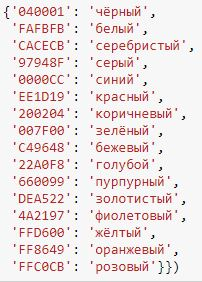

Реализум программно замену кода цвета на его наименование через функцию process_color и обработаем значание рассматриваемого признака в тренировочгном датасете:

In [24]:
train['color'] = train['color'].apply(process_color)
train['color'].value_counts()

чёрный         24458
белый          15300
серебристый    11171
серый          10573
синий           8653
красный         4469
коричневый      3517
зелёный         2563
бежевый         1831
голубой         1390
золотистый       768
пурпурный        743
желтый           696
фиолетовый       602
оранжевый        505
розовый           25
Name: color, dtype: int64

**Вывод**. Привели данные по цветам автомобилей в тестовом и тренировочном датасетах к единому представлению. Данный признак является категориальным.

In [25]:
cat_cols.append('color')

***3.3.4. Признак fuelType***

Сопоставим содержимое признака *fuelType* (тип топлива у автомобиля) в тестовом и тренировочном датасетах:

In [26]:
test['fuelType'].value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [27]:
train['fuelType'].value_counts()

бензин       73365
дизель       13487
гибрид         291
электро        109
газ             11
универсал        1
Name: fuelType, dtype: int64

**Вывод**. Типовые значения данных в тестовом и тренировочном датасете рассматриваемого признака совпадают. Дополнительной обработки не требуется. Считаем данный признак категориальным.

In [28]:
cat_cols.append('fuelType')

***3.3.5. Признак modelDate***

Сопоставим данные признака *modelDate* (год начала выпуска модели автомобиля) в тестовом и тренировочном датасетах:

In [29]:
test['modelDate'].value_counts()

2010    2503
2013    2275
2008    2243
2011    2173
2006    2169
        ... 
1973       1
1965       1
1969       1
1934       1
1960       1
Name: modelDate, Length: 66, dtype: int64

In [30]:
train['modelDate'].value_counts()

2006.00    6101
2010.00    5866
2009.00    5662
2017.00    5152
2011.00    4728
           ... 
1969.00       1
1934.00       1
1950.00       1
1904.00       1
1948.00       1
Name: modelDate, Length: 78, dtype: int64

Видно, что при одинаковой смысловой нагрузке, данные в тестовом и тренировочном датасетах имеют различный тип данных. Требуется преобразовать данные к единому типу. За основу возьмем тип данных из тренировочного датасета.

In [31]:
test['modelDate'] = test['modelDate'].astype(float)
test['modelDate'].value_counts()

2010.00    2503
2013.00    2275
2008.00    2243
2011.00    2173
2006.00    2169
           ... 
1973.00       1
1965.00       1
1969.00       1
1934.00       1
1960.00       1
Name: modelDate, Length: 66, dtype: int64

**Вывод**. Привели данные по рассматриваемому признаку к единому типу данных. Признак *modelDate* является числовым.

In [32]:
num_cols.append('modelDate')

***3.3.6. Признак name***

Сопоставим данные признака *name* (сводные характеристики модели автомобиля) в тестовом и тренировочном датасетах:

In [33]:
test['name'].value_counts()

1.6 AT (110 л.с.)         631
1.6 MT (102 л.с.)         410
1.6 MT (110 л.с.)         314
2.0 CVT (141 л.с.) 4WD    309
1.4 AMT (122 л.с.)        308
                         ... 
2.1 MT (170 л.с.)           1
4.2 AT (245 л.с.) 4WD       1
3.5d MT (115 л.с.) 4WD      1
3.0 AT (223 л.с.)           1
300 3.0 AT (218 л.с.)       1
Name: name, Length: 2780, dtype: int64

In [34]:
train['name'].value_counts()

2.0 AT (150 л.с.)            1568
1.6 AT (123 л.с.)            1297
1.6 AT (110 л.с.)            1090
1.6 MT (105 л.с.)             884
1.4 MT (75 л.с.)              778
                             ... 
2.0 CVT (140 л.с.) 4WD          1
Cedia 1.5 MT (91 л.с.)          1
2.0 MT (245 л.с.)               1
4.1d AT (155 л.с.) 4WD          1
StreetKa 1.6 MT (95 л.с.)       1
Name: name, Length: 4484, dtype: int64

**Вывод**. Получены однотипные данные в различных датасетах. Унификацию данных производить не нужно. Рассматривемый признак считаем категориальным.

In [35]:
cat_cols.append('name')

***3.3.7. Признак numberOfDoors***

Сопоставим данные признака *numberOfDoors* (количество дверей в автомобиле) в тестовом и тренировочном датасете:

In [36]:
test['numberOfDoors'].value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [37]:
train['numberOfDoors'].value_counts()

5.00    50208
4.00    32980
3.00     2197
2.00     1877
0.00        1
Name: numberOfDoors, dtype: int64

Видно, что данные в тестовом и тренировочном датасетах имеют различный тип данных. Требуется преобразовать данные к единому типу. Будем использовать тип данных из тренировочного датасета.

In [38]:
test['numberOfDoors'] = test['numberOfDoors'].astype(float)
test['numberOfDoors'].value_counts()

5.00    18703
4.00    14126
2.00     1206
3.00      650
0.00        1
Name: numberOfDoors, dtype: int64

**Вывод**. Привели данные по рассматриваемому признаку к единому типу данных. Признак *numberOfDoors* является числовым.

In [39]:
num_cols.append('numberOfDoors')

***3.3.8. Признак productionDate***

Сопоставим данные признака *productionDate* (год выпуска конкретного автомобиля) в тестовом и тренировочном датасетах:

In [40]:
test['productionDate'].value_counts()

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1904       1
1936       1
1968       1
1939       1
1948       1
Name: productionDate, Length: 69, dtype: int64

In [41]:
train['productionDate'].value_counts()

2020    11126
2008     6995
2012     6580
2011     6154
2013     5554
        ...  
1955        1
1948        1
1971        1
1931        1
1949        1
Name: productionDate, Length: 80, dtype: int64

**Вывод**. Данные однотипные. Дополнительных преобразований производить не нужно. Рассматриваемый признак является числовым.

In [42]:
num_cols.append('productionDate')

***3.3.9. Признак vehicleConfiguration***

Сопоставим данные признака *vehicleConfiguration* (сводная конфигурация) в тестовом и тренировочном датасетах:

In [43]:
test['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0     2389
SEDAN AUTOMATIC 2.0               1610
ALLROAD_5_DOORS AUTOMATIC 2.0     1327
ALLROAD_5_DOORS VARIATOR 2.0      1323
SEDAN MECHANICAL 1.6              1314
                                  ... 
SEDAN_HARDTOP MECHANICAL 2.0         1
PICKUP_ONE_HALF AUTOMATIC 5.7        1
ALLROAD_3_DOORS MECHANICAL 4.2       1
FASTBACK MECHANICAL 2.8              1
ALLROAD_OPEN AUTOMATIC 2.0           1
Name: vehicleConfiguration, Length: 634, dtype: int64

In [44]:
train['vehicleConfiguration'].value_counts()

SEDAN MECHANICAL 1.6                 4130
SEDAN AUTOMATIC 1.6                  3519
ALLROAD_5_DOORS VARIATOR 2.0         2762
ALLROAD_5_DOORS AUTOMATIC 2.0        2759
SEDAN AUTOMATIC 2.0                  2183
                                     ... 
SEDAN AUTOMATIC 4.1                     1
COUPE MECHANICAL 420i                   1
SEDAN AUTOMATIC 7.0                     1
CABRIO AUTOMATIC 8.2                    1
HATCHBACK_3_DOORS VARIATOR Hybrid       1
Name: vehicleConfiguration, Length: 1860, dtype: int64

**Вывод**. Видно, что данные имеют однотипную структуру построения. Дополнительных обработок данных в тренировочной базе не требуется. Признак *vehicleConfiguration* является категориальным.

In [45]:
cat_cols.append('vehicleConfiguration')

***3.3.10. Признак vehicleTransmission***

Сопоставим значения данных признака *vehicleTransmission* (используемая в автомобиле трансмиссия) в тестовом и тренировочном датасетах:

In [46]:
test['vehicleTransmission'].value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [47]:
train['vehicleTransmission'].value_counts()

AUTOMATIC     48029
MECHANICAL    25075
ROBOT          7550
VARIATOR       6609
Name: vehicleTransmission, dtype: int64

Данные по рассматриваемому признаку в тренировочном датасете представлены на английском языке, в тестовом - на русском. Требуется приведение к варианту тестового датасета. Создадим функцию для требуемого преобразования *process_vehicleTransmission* и обработаем данный признак в тренировочной базе.

In [48]:
train['vehicleTransmission'] = train['vehicleTransmission'].apply(process_vehicleTransmission)
train['vehicleTransmission'].value_counts()

автоматическая      48029
механическая        25075
роботизированная     7550
вариатор             6609
Name: vehicleTransmission, dtype: int64

**Вывод**. Произвели нужное преобразование названий признака *vehicleTransmission*, для унификации с тествым датасетом. Получили категориальный признак.

In [49]:
cat_cols.append('vehicleTransmission')

***3.2.11. Признак engineDisplacement***

Сопоставим данные признака *engineDisplacement* (объем двигателя автомобиля) в тестовом и тренировочном датасетах:

In [50]:
test['engineDisplacement'].value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [51]:
train['engineDisplacement'].value_counts()

1.6           16722
2.0           12867
1.4            5549
1.8            5076
2.4            3190
              ...  
ST170             1
StreetKa          1
PowerShift        1
Shuttle           1
6.7d              1
Name: engineDisplacement, Length: 534, dtype: int64

Произведем преобразование данных в тренировочном датасете, к формату данных в тестовом датасете. для этого воспользуемся пользовательской функцией *process_engineDisplacement*:

In [52]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: str(x)+' LTR')
train['engineDisplacement'].value_counts()

1.6 LTR           16722
2.0 LTR           12867
1.4 LTR            5549
1.8 LTR            5076
2.4 LTR            3190
                  ...  
StreetKa LTR          1
PowerShift LTR        1
Shuttle LTR           1
nan LTR               1
6.7d LTR              1
Name: engineDisplacement, Length: 535, dtype: int64

**Вывод**. Почти все значения из тестовго датасета присутствуют в составе тренировочного. При этом, еще остается возможность переработки данных рассматриваемого признака тренировочного датасета для улушения получаемой ML-модели. Оставим данный вопрос на перспективные исследования. Признак *engineDisplacement* получился категориальный.

In [53]:
cat_cols.append('engineDisplacement')

***3.3.12. Признак enginePower***

Сопоставим содержимое данных признака *enginePower* (мощность двигателя автомобиля) в тестовом и тренировочном датасетах:

In [54]:
test['enginePower'].value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
514 N12       1
626 N12       1
38 N12        1
32 N12        1
301 N12       1
Name: enginePower, Length: 315, dtype: int64

In [55]:
train['enginePower'].value_counts()

150.00    6854
249.00    3485
140.00    2852
105.00    2348
123.00    2192
          ... 
321.00       1
232.00       1
236.00       1
437.00       1
591.00       1
Name: enginePower, Length: 396, dtype: int64

В данном случае, имеет смысл привести данные в тестовом датасете к представлению данных в тренировочном датасете - уберем " N12" и преобразуем к float64. В итоге получим однотипные данные, доступные для сляиния.

In [56]:
test['enginePower'] = pd.to_numeric(test['enginePower'].apply(lambda x: x.split(' ')[0])).astype(float)
test['enginePower'].value_counts()

249.00    1708
150.00    1699
110.00    1039
170.00     977
105.00     955
          ... 
514.00       1
626.00       1
38.00        1
32.00        1
301.00       1
Name: enginePower, Length: 315, dtype: int64

**Вывод**. Привели данные в тестовом датасете к формату данных тренировочного. Получили числовой признак *enginePower*.

In [57]:
num_cols.append('enginePower')

***3.3.13. Признак description***

Сопоставим данные признака *description* (общее описание автомобиля) в тестовом и тренировочном датасете. Т.к. признак представляет собой произвольное текстовое описание от продавца автомобиля, то для срванения используем по однму произвольному значению из каждого датасета.

In [58]:
test['description'][800]

'Автомобиль в хорошем состоянии, без кузовного ремонта , ухожен, обслужен, все родное, сел и поехал, возможен торг.'

In [59]:
train['description'][800]

'На хорошем ходу,все что нужно было менять менялось,есть небольшие косяки по кузову,стоит новое сцепление,торг у капота,по остальным вопросам отвечу лично\nОбмен с вашей доплатой\n'

**Вывод**. Видно, что данные однотипные, но не структуированые. Имеют описательный характер. В перспективе, можно рассмотреть выборку дополнительных данных для проектирования новых признаков или заполнения пропусков.

***3.3.14. Признак mileage***

Сопоставим данные признака *mileage* (пробег автомобиля) в тестовом и тренировочном датасетах:

In [60]:
test['mileage'].value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
140237      1
121449      1
210311      1
121363      1
157965      1
Name: mileage, Length: 11268, dtype: int64

In [61]:
train['mileage'].value_counts()

0         12017
200000     1133
150000     1042
180000      891
160000      857
          ...  
256412        1
142282        1
61089         1
44004         1
191768        1
Name: mileage, Length: 17403, dtype: int64

**Вывод**. Значения данных в рассматриваемом признаке тренировочного датасета аналогичны данным тестового датасета по смысли у типу данных. Дополнительных преобразований не требуется. Включаем данный признак в числовые признаки.

In [62]:
num_cols.append('mileage')

***3.3.15. Признак Комплектация***

Признака с наименованием *Комплектация* в тестовом датасете нет. Но в нем есть признак *complectation_dict*, который может соответствовать исходному признаку тренировочного датасета. Проверим это утвержднение, взяв не пустые записи из обоих датасетов.

In [63]:
test['complectation_dict'][2]

'{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'

In [64]:
train['Комплектация'][89375]

"{'id': '10408082', 'name': 'Luxury', 'available_options': ['cruise-control', 'multi-wheel', 'airbag-passenger', 'roof-rails', 'lock', 'electro-mirrors', 'mirrors-heat', 'leather', 'seat-transformation', 'wheel-power', 'airbag-side', 'abs', 'wheel-leather', 'third-row-seats', 'climate-control-1', 'auto-mirrors', 'esp', 'usb', 'audiopreparation', 'electro-window-back', 'hatch', '17-inch-wheels', 'body-mouldings', 'wheel-heat', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'electro-window-front', 'passenger-seat-electric', 'alarm', 'leather-gear-stick', 'ptf', 'rain-sensor', 'audiosystem-cd', 'front-seats-heat', 'bluetooth', 'wheel-configuration1', 'immo', 'third-rear-headrest'], 'vendor_colors': [{'body_color_id': 20620323, 'mark_color_id': 21391027, 'name_ru': 'Черный', 'color_type': 'METALLIC', 'stock_color': {'hex_code': '040001', 'name_ru': 'черный'}, 'photos': [{'name': '34-front', 'sizes': {'orig': '//avatars.mds.yandex.net/get-verba/787013/2a000001609b9d3b0fed7c022e806

Видно, что в обоих реквизитах содержится однотипный словарь комплектации автомобиля, предположительно в формате JSON Переименуем признак *Комплектация* в тренировочной базе в *complectation_dict* для унификации с тествым датасетом.

In [65]:
train.rename(columns={'Комплектация':'complectation_dict'}, inplace=True)

**Вывод**. Значания данного признака дают много дополнительной информации по автомобилю и он может быть использован для генерации дополнительных признаков в обучаючающей выборке. Оставим данный признак для последующего использования в уточненных моделях.

***3.3.16. Признак Привод***

Сопоставим данные признака *Привод* (тип привода автомобиля) в тестовом и тренировочном датасетах:

In [66]:
test['Привод'].value_counts()

передний    15565
полный      15020
задний       4101
Name: Привод, dtype: int64

In [67]:
train['Привод'].value_counts()

передний    46510
полный      33803
задний       6950
Name: Привод, dtype: int64

**Вывод**. Полное соответствие значений параметра. Используем данный признак - "как есть". Данный признак является категориальным.

In [68]:
cat_cols.append('Привод')

***3.3.17. Признак Руль***

Сопоставим данные признака *Руль* (тип рулевого управления) в тестовом и тренировочном датасетах:

In [69]:
test['Руль'].value_counts()

Левый     33287
Правый     1399
Name: Руль, dtype: int64

In [70]:
train['Руль'].value_counts()

LEFT     85481
RIGHT     1783
Name: Руль, dtype: int64

Требуется замена англоязычного названия расположения руля на русскоязычное. Воспользуемся созданной специализированной функцией process_wheel для преобразования данного признака в тренировочном датасете.

In [71]:
train['Руль'] = train['Руль'].apply(process_wheel)
train['Руль'].value_counts()

Левый     85481
Правый     1783
Name: Руль, dtype: int64

**Вывод**. Произвели преобразования признака *Руль* к формату в тестовом датасете. Получили, что данный признак является бинарным.

In [72]:
bin_cols.append('Руль')

***3.3.18. Признак Состояние***

Сопоставим данные признака *Состояние* (состояние автомобиля с позиции ремонта) в тестовом и тренировочном датасетах:

In [73]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [74]:
train['Состояние'].value_counts()

Series([], Name: Состояние, dtype: int64)

**Вывод**. Признак *Состояние* не заполнен в тренировочной базе, а в тестовой базе имеет одно и тоже значение. В данном случае, этот признак не имеет значения для ML-модели и может быть опущен. Удалим его в обоих датасетах.

In [75]:
test.drop(['Состояние'], axis=1, inplace=True)
train.drop(['Состояние'], axis=1, inplace=True)

***3.3.19. Признак Владельцы***

Сопоставим данные признака *Владельцы* (количество предыдущих владельцев автомобиля) в тестовом и тренировочном датасетах:

In [76]:
test['Владельцы'].value_counts()

3 или более    15957
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [77]:
train['Владельцы'].value_counts()

3.00    36011
2.00    20867
1.00    18369
Name: Владельцы, dtype: int64

Видно, что значения признаков в рассматриваемых датасетах имеют разный тип, хотя по смыслу означают одно и то же. С учетом подготовки данного признака для использования в ML-модели, необходимо преобразовать эти данные в тестовом датасете к числовому типу, предварительно взяв из значений только первый символ.

In [78]:
test['Владельцы'] = pd.to_numeric(test['Владельцы'].apply(lambda x: x[0])).astype(float)
test['Владельцы'].value_counts()

3.00    15957
1.00     9459
2.00     9270
Name: Владельцы, dtype: int64

**Вывод**. Привели признак *Владельцы* к одному виду в обоих датасетах, а так же подготовили его для использования в модели. Данный признак будем считать числовым.

In [79]:
num_cols.append('Владельцы')

***3.3.20. Признак ПТС***

Сопоставим данные признака *ПТС* (тип ПТС) в тестовом и тренировочном датасетах:

In [80]:
test['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [81]:
train['ПТС'].value_counts()

ORIGINAL     76556
DUPLICATE    10351
Name: ПТС, dtype: int64

При обработке данного признака в тренировочном датасете, требуется замена англоязычного названия типа ПТС на русскоязычное. Используя созданную функцию *process_vp*, преобразуем данные рассматриваемого признака в тренировочном датасете.

In [82]:
train['ПТС'] = train['ПТС'].apply(process_vp)
train['ПТС'].value_counts()

Оригинал    76556
Дубликат    10351
Name: ПТС, dtype: int64

**Ввод**. Получили унифицированные значения рассматриваемого признака в тестовом и тренировочном датасете. Данный принак является бинарным.

In [83]:
bin_cols.append('ПТС')

***3.3.21. Признак Таможня***

Сопоставим данные признака *Таможня* (таможенное сосотяние автомобиля) в тестовом и тренировочном датасете:

In [84]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

In [85]:
train['Таможня'].value_counts()

True    87264
Name: Таможня, dtype: int64

**Вывод**. Признак *Таможня* заполнен в тестовой и тренировочной базе одним и тем же, по смыслу, значением - автомобиль являнтся растоможенным. Т.к данный признак является константой, то он не представлет ценности для создаваемой ML-модели и может быть опущен. Удалим его в обоих датасетах.

In [86]:
test.drop(['Таможня'], axis=1, inplace=True)
train.drop(['Таможня'], axis=1, inplace=True)

***3.3.22. Признак start_date***

Рассмотрим содержимое признака *start_date*, который присутствует только в тренировочном датасете:

In [87]:
train['start_date']

0        2019-10-03T08:09:11Z
1        2020-09-06T06:49:40Z
2        2020-09-02T14:04:21Z
3        2020-08-23T17:40:09Z
4        2020-09-08T09:22:07Z
                 ...         
89373    2020-02-11T09:29:59Z
89374    2020-05-30T18:56:30Z
89375    2020-08-30T14:39:15Z
89376    2019-05-14T15:43:20Z
89377    2020-08-10T11:30:29Z
Name: start_date, Length: 87264, dtype: object

Судя по его названию и содержимому - это дата подачи объявления о продаже автомобиля на сайте *auto.ru*. Для удобства, приведем его к формату *datatime*.

In [88]:
train['start_date'] = pd.to_datetime(train['start_date'])
train['start_date']

0       2019-10-03 08:09:11+00:00
1       2020-09-06 06:49:40+00:00
2       2020-09-02 14:04:21+00:00
3       2020-08-23 17:40:09+00:00
4       2020-09-08 09:22:07+00:00
                   ...           
89373   2020-02-11 09:29:59+00:00
89374   2020-05-30 18:56:30+00:00
89375   2020-08-30 14:39:15+00:00
89376   2019-05-14 15:43:20+00:00
89377   2020-08-10 11:30:29+00:00
Name: start_date, Length: 87264, dtype: datetime64[ns, UTC]

**Вывод**. Т.к. данный признак не имеет аналога в тестовой базе, то он не окажет влияния на качество результатов ML-модели при проверке на тестовом датасете. Но данный признак может потребоваться при проектировании других признаков.

***3.3.23. Признак Владение***

Сопоставим данные признака *Владение* (срок последнего владения автомобилем) в тестовом и тренировочном датасетах:

In [89]:
test['Владение'].value_counts()

1 год и 10 месяцев      209
2 года                  197
1 год                   194
1 год и 1 месяц         193
1 год и 2 месяца        187
                       ... 
42 года и 10 месяцев      1
23 года и 2 месяца        1
34 года и 2 месяца        1
28 лет и 8 месяцев        1
22 года и 9 месяцев       1
Name: Владение, Length: 275, dtype: int64

In [90]:
train['Владение'].value_counts()

{'year': 2018, 'month': 10}    495
{'year': 2019, 'month': 8}     491
{'year': 2018, 'month': 8}     487
{'year': 2018, 'month': 9}     472
{'year': 2018, 'month': 11}    472
                              ... 
{'year': 2001, 'month': 3}       1
{'year': 1982, 'month': 3}       1
{'year': 1992, 'month': 2}       1
{'year': 1998, 'month': 6}       1
{'year': 1997, 'month': 7}       1
Name: Владение, Length: 290, dtype: int64

Видно, что в рассматриваемом признаке тестового датасета приведен **срок** владения автомобилем продавцом в годах и месяцах. В тренировочном датасете эти же данные представлены как **дата начала** владения автомобилем продавцом, также в годах и месяцах. Для приведения значений этих данных к единому формату, выразим в обоих случаях значения в суммарном количестве месяцев владения автомобилем продавцом.

Будем исходить из предположения, что в тестовом датасете срок владения автомобилем отсчитывается до момента подачи объявления. Тогда получение нужного значения будет определяться как полная сумма месяцев из указанного в признаке *Владении* периода (расчет реализован через пользовательскую функцию process_ownership_test):

In [91]:
test['ВладениеМес'] = test['Владение'].apply(process_ownership_test)
test['ВладениеМес'] = test['ВладениеМес'].fillna(0)
test['ВладениеМес'].value_counts()

0.00      22691
22.00       209
24.00       197
12.00       194
13.00       193
          ...  
514.00        1
278.00        1
410.00        1
344.00        1
273.00        1
Name: ВладениеМес, Length: 276, dtype: int64

При обработке данного признака, также провели заполнение пропусков в данном признаке. Эти значения нам потребуются в дальнейшем.

Исходя из того же предположения, что в тренировочном датасете дата начала владения автомобилем отсчитывается от даты указанной в признаке *start_date* до момента подачи объявления о продажи, можно рассчтитать суммарный срок владения в месяцах:

In [92]:
train['ВладениеНачало'] = train['Владение'].fillna(0)
train['ВладениеНачало'] = train.apply(process_ownership_train1, axis=1)
train['ВладениеКонец'] = train['start_date'].dt.year * 12 + train['start_date'].dt.month
train['ВладениеМес'] = train.apply(process_ownership_train2, axis=1).astype(float)
train['ВладениеМес'].value_counts()

0.00      58681
12.00       596
24.00       499
23.00       496
9.00        494
          ...  
278.00        1
190.00        1
265.00        1
210.00        1
234.00        1
Name: ВладениеМес, Length: 284, dtype: int64

Удалим исходные и вспомогательные признаки:

In [93]:
test.drop(['Владение'], axis=1, inplace=True)
train.drop(['Владение'], axis=1, inplace=True)
train.drop(['ВладениеНачало'], axis=1, inplace=True)
train.drop(['ВладениеКонец'], axis=1, inplace=True)

**Вывод**. Получили в тестовом и тренировочном датасетах новый признак *ВладениеМес*, который отпражает, где возможно, данные по количеству месяцев владения автомобиля последним владельцем. Новый признак является числовым.

In [94]:
num_cols.append('ВладениеМес')

***3.3.24. Признак hidden***

Рассмотрим содержимое признака *hidden*, который присутствует только в тренировочном датасете:

In [95]:
train['hidden'].describe()

count   0.00
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: hidden, dtype: float64

Из приведенного описания видно, что данный признак не имеет ни одного значения. В связи с отсутвием информативности для создаваемой модели, будем использовать данный признак как служебный - в нем будет храниться признак принадлежности данных к тестовым (1) или тренировочным данным (0). Для удобства, преименуем данный признак тренировочном дататсете, а также заполним его соответствующими значениями в обоих датасетах:

In [96]:
train.rename(columns={'hidden':'test_data'}, inplace=True)
train['test_data'] = 0
test['test_data'] = 1

**Вывод**. Признак *test_data* тренировочного датасета будет хранить флаг принадлежности строки к тествовому датасету. Потребуется для последующего разделения общего датасета после окончательной обработки признаков. Поместим его в список служебных признаков.

In [97]:
serv_cols.append('test_data')

***3.3.25. Признак model***

Признак с наименованием *model* отсутствует в тестовом датасете. Для сопоставления данного признака одному из признаков тестового датасета, расмотрим возможные значения данного признака:

In [98]:
train['model'].value_counts()

FOCUS                 2464
SOLARIS               1686
5ER                   1643
ASTRA                 1545
RIO                   1449
                      ... 
100_SERIES               1
LTD_CROWN_VICTORIA       1
GRANADA                  1
FREESTYLE                1
URVAN                    1
Name: model, Length: 1086, dtype: int64

Значения данного признака соответствуют аналогичным значениям признака *model_name* в тестовом датасете:

In [99]:
test['model_name'].value_counts()

OCTAVIA     1418
5ER         1026
LANCER       855
E_KLASSE     809
PASSAT       782
            ... 
MR_S           1
VELLFIRE       1
VERSO_S        1
Z3M            1
PLATZ          1
Name: model_name, Length: 544, dtype: int64

Как видно из сравнения значения данных этих признаков, дополнительных преобразований данных не требуется. Необходимо только переименовать название признака в тренировочном датасете для упрощения последующей процедуры слияния датасетов.

In [100]:
train.rename(columns={'model':'model_name'}, inplace=True)

**Вывод**. Данный признак является категориальным. Добавим его в наш список соответствующих признаков.

In [101]:
cat_cols.append('model_name')

***3.3.26. Признак price***

Признак *price* является целевым. Он отсутствует в тестовом датасете, но присутствует в тренировочном. Используется для обучения создаваемой ML-модели. Рассмотрим его более внимательно, после первичного преобразования тренировоччного датасета.

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87264 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   bodyType              87264 non-null  object             
 1   brand                 87264 non-null  object             
 2   color                 87264 non-null  object             
 3   fuelType              87264 non-null  object             
 4   modelDate             87263 non-null  float64            
 5   name                  87263 non-null  object             
 6   numberOfDoors         87263 non-null  float64            
 7   productionDate        87264 non-null  int64              
 8   vehicleConfiguration  87263 non-null  object             
 9   vehicleTransmission   87263 non-null  object             
 10  engineDisplacement    87264 non-null  object             
 11  enginePower           87263 non-null  float64            
 12  desc

Из отчета выидно, что признак *price* имеет пропуски (заполнено 86854 из 87264 значений). Т.к., логично предположить, что стоимость автомобиля при продаже не может быть равна нулю, то для более точного предсказания цены создаваемой моделью, нам необходимо убрать строки тренировочного датасета, где цена не указана.

In [103]:
train.dropna(subset=['price'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86854 entries, 0 to 89377
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   bodyType              86854 non-null  object             
 1   brand                 86854 non-null  object             
 2   color                 86854 non-null  object             
 3   fuelType              86854 non-null  object             
 4   modelDate             86853 non-null  float64            
 5   name                  86853 non-null  object             
 6   numberOfDoors         86853 non-null  float64            
 7   productionDate        86854 non-null  int64              
 8   vehicleConfiguration  86853 non-null  object             
 9   vehicleTransmission   86853 non-null  object             
 10  engineDisplacement    86854 non-null  object             
 11  enginePower           86853 non-null  float64            
 12  desc

Рассмотрим распределение цены автомобиля после очистки нулевых цен:

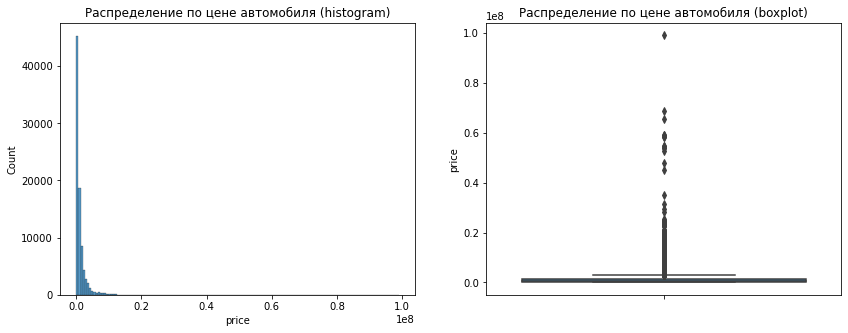

In [104]:
number_graph(train, 'price', 'Распределение по цене автомобиля')

In [105]:
train['price'].describe()

count      86854.00
mean     1260891.85
std      1923664.83
min        16000.00
25%       350000.00
50%       649000.00
75%      1400000.00
max     99000000.00
Name: price, dtype: float64

Видно, что основое количество предлагаемых цен сосредоточено в диапазоне от 16 т.р. до примерно 1,2-1,4 млн.р. Есть достаточно большое количество выбросов вплоть до цены 99 млн.р. При этом распределение не является нормальным, что может быть критично для некоторых ML-моделей. Попробуем исправить эту ситуацию с помощью логарифмирования целевого признака цены.

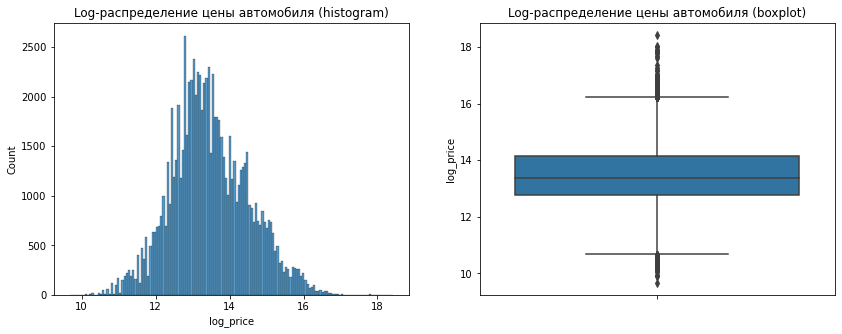

In [106]:
train['log_price'] = train['price'].apply(lambda x: np.log(x))
number_graph(train, 'log_price', 'Log-распределение цены автомобиля')
train = train.drop(['log_price'], axis=1)

После логарифмирования признака цены автомбиля распределение сдало более "нормальным". Необходимо учесть данное свойтво при работе с моделями в дальнейшем.

В тестовом датасете отсутствует рассматриваемый признак. Так как будет необходимо обединять датасеты, то добавми этот признак и заполним его нулевыми значениями, т.к. их еще предстоит найти.

In [107]:
test['price'] = 0

**Вывод**. Произведена подготовака тренировочного и тестового датасетов для работы с целевым признаком *price*. Занесем данный признак в список служебных.

In [108]:
serv_cols.append('price')

***3.4. Объединение датасетов***

Для последующего операций для EDA, необходимо объединить тестовый и тренировочные датасеты.

Перед этим необходимо произвести дополнительную подготовку в тренировочном датасете. Для формирования файла итогов для Kaggle (*submission.csv*) требуется признак *sell_id*, которого нет в тренировочном датасете. Создадим этот признак и заполним его нулевыми значениями и занесем в список служебных признаков.

In [109]:
train['sell_id'] = 0
serv_cols.append('sell_id')

Объединим тренировочный и тестовый датасеты по выделенным в отдельные списки признакам.

In [110]:
train_data = train[cat_cols + num_cols + bin_cols + serv_cols]
test_data = test[cat_cols + num_cols + bin_cols + serv_cols]
all_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121540 entries, 0 to 121539
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              121540 non-null  object 
 1   brand                 121540 non-null  object 
 2   color                 121540 non-null  object 
 3   fuelType              121540 non-null  object 
 4   name                  121539 non-null  object 
 5   vehicleConfiguration  121539 non-null  object 
 6   vehicleTransmission   121539 non-null  object 
 7   engineDisplacement    121540 non-null  object 
 8   Привод                121539 non-null  object 
 9   model_name            121540 non-null  object 
 10  modelDate             121539 non-null  float64
 11  numberOfDoors         121539 non-null  float64
 12  productionDate        121540 non-null  int64  
 13  enginePower           121539 non-null  float64
 14  mileage               121540 non-null  int64  
 15  

**Вывод**. Произвели объединенение тестового и тренировочного датасетов и получили объединенный датасет, в котором далее будут производится дальнейшие операции: разведочный анализ данных (EDA) и подготовка их к использованию в ML-моделях.

***3.5. Обработка данных в объединенном датасете***

Начнем обработку данных в объединенном датасете с анализа пропусков и заполнению недостающих данных.

***3.5.1. Анализ пропусков данных***

По информации полученной в результате п.3.4 (*all_data.info()*) получены следующие признаки с пропусками:
- *name*, *vehicleConfiguration*, *vehicleTransmission*, *Привод*, *modelDate*, *numberOfDoors*, *enginePower* - 1 пропуск;
- *ПТС* - 358 пропусков;
- *Владельцы* - 11998 пропусков.

В зависимости от количества пропусков будем использовать разные методы их заполнения.

***3.5.1.1. Заполнение одиночных пропусков данных***

Для признаков первый группы, имеющих одиночные пропуски, воспользуемся аналитическим методом заполнения, основанным на анализе содержимого других признаков в строке с интересующим нас пропуском.

Найдем в объединенном датасете строку с пропуском в одном из указанных ранее признаков:

In [111]:
all_data[all_data['name'].isnull()]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
23940,nan,HONDA,серебристый,универсал,NaN,NaN,NaN,nan LTR,NaN,CIVIC,...,1989,NaN,400000,3.00,0.00,Левый,Оригинал,0,120000.00,0


Видно, что все одиночные пропуски, котрые были найдены ранее, содержаться в одной строке. Т.е. мы имеем один и тот же автомобиль, у которого не заполнено несколько нужных нам признаков. Находим по индексу из объединенного датасета аналогичную строку в тренировочном датасете (т.к. all_data.test_data=0), для определения возможности получения дополнительной информации по автомобилю.

In [112]:
train.iloc[23940]

bodyType                                                              nan
brand                                                               HONDA
color                                                         серебристый
fuelType                                                        универсал
modelDate                                                             NaN
name                                                                  NaN
numberOfDoors                                                         NaN
productionDate                                                       1989
vehicleConfiguration                                                  NaN
vehicleTransmission                                                   NaN
engineDisplacement                                                nan LTR
enginePower                                                           NaN
description             Продаю Honda Civic Suttle 1989 г. выпуска, неу...
mileage                               

Из доступных для данной записи признаков, нам представляет интерес подробное рассмотрение информации из признака *description*:

In [113]:
train.iloc[23940]['description']

'Продаю Honda Civic Suttle 1989 г. выпуска, неубиваемая рабочая лошадка со спортивным норовом. Потрясающая динамика, проходимость и управляемость. Требует небольшие сварочные работы (замена порогов). Имеется  еще запасной капот и  кардан. Возможен торг при осмотре.'

Используя информацию по названию модели и данные по году выпуска автомобиля, на сайте *auto.ru* находим и заполняем в датасете недостающие характеристики модели (https://auto.ru/catalog/cars/honda/shuttle/4927736/4927737/specifications/):

In [114]:
all_data['bodyType'].iloc[23940] = 'компактвэн'
all_data['fuelType'].iloc[23940] = 'бензин'
all_data['name'].iloc[23940] = '2.2 AT (150 л.с.)'
all_data['vehicleConfiguration'].iloc[23940] = 'COMPACTVAN AUTOMATIC 2.2'
all_data['vehicleTransmission'].iloc[23940] = 'автоматическая'
all_data['engineDisplacement'].iloc[23940] = '2.2 LTR'
all_data['Привод'].iloc[23940] = 'передний'
all_data['modelDate'].iloc[23940] = 1994
all_data['numberOfDoors'].iloc[23940] = 5
all_data['enginePower'].iloc[23940] = 150

In [115]:
all_data.iloc[23940]

bodyType                              компактвэн
brand                                      HONDA
color                                серебристый
fuelType                                  бензин
name                           2.2 AT (150 л.с.)
vehicleConfiguration    COMPACTVAN AUTOMATIC 2.2
vehicleTransmission               автоматическая
engineDisplacement                       2.2 LTR
Привод                                  передний
model_name                                 CIVIC
modelDate                                1994.00
numberOfDoors                               5.00
productionDate                              1989
enginePower                               150.00
mileage                                   400000
Владельцы                                   3.00
ВладениеМес                                 0.00
Руль                                       Левый
ПТС                                     Оригинал
test_data                                      0
price               

**Вывод**. Исходя из доступной информации для строки датасета, в котрой присутствовали одиночные пропуски различных признаков, восстановили все данные указанной записи. 

***3.5.1.2. Заполнение пропусков данных в признаке ПТС***

Рассмотрим содержимое признака *ПТС* более подробно:

In [116]:
all_data['ПТС'].value_counts()

Оригинал    106288
Дубликат     14894
Name: ПТС, dtype: int64

Видно, что для имеющихся в признаке значениях преобладают оригиналы ПТС.

Попробуем получить данные о недостающих ПТС из признака *description*, который ранее отмечался, как возможный источник дополнительной информации. Посчитаем количество записей с пропусками признака *ПТС* у которых есть упоминание о ПТС в признаке *description*:

In [117]:
idx = all_data[all_data['ПТС'].isnull()].index
s = 0
for i in idx:
    try:
        desc = str(train.iloc[i]['description']).lower()
        if desc.find('птс') >= 0:
            s +=1
    except:
        pass
print(s)

26


Таких записей получили 26 шт., что позволяет провести их визуальный просмотр и сделать заключение по каждой. Опуская программный код формирования содержимого принака *description* выбранных записей, сразу же сделаем вывод по результатам их просмотра. Все полученные описательные признаки представлют собой стандартные объявления о продаже повых автомобилей автосалонов. Упоминания ПТС в этих объявлениях говорят о наличии этих ПТС у продаваемых автомобилей, не оформленных на конечного покупателя, но формально существующих. Это позволяет сделать заключения, что во всех 26 строках признак *ПТС* можно  устанавливать в значение "Оригинал".

Т.к. больше в исходном датасете нет данных из которых можно получить достоверную информацию по ПТС, то далее будем использовать аналитический метод заполнения пропусков данного признака. Приняв во внимание, что ПТС (паспорт транспортного средства) выдается всем автомобилям, т.е. изначально у каждого транспортного средства должен быть оригинал ПТС, а так же то, что процент дубликатов ПТС по отношению к оригиналам ПТС - 14,01% (~14%), можно произвести заполнение 358 пропусков ПТС значением "Оригинал". Данное утвеждение, так же включет в себя результаты анализа ПТС по признаку *description*.

In [118]:
all_data['ПТС'][all_data['ПТС'].isnull()] = 'Оригинал'
all_data['ПТС'].value_counts()

Оригинал    106646
Дубликат     14894
Name: ПТС, dtype: int64

**Вывод**. Произвели заполнение признака *ПТС* одинаковым значением "Оригинал", которое либо достоверно определено по другим признакам, либо наиболее верояно для пропущеных значений. При этом общее соотношение дубликатов и оригиналов ПТС в датасете практически не изменилось и равно 13,96% (~14%).

*Примечание*. Обнаруживается большой дисбаланс бинарного признака. Необходимо учесть данное замечание в дальнейшем.

***3.5.1.3. Заполнение пропусков данных в признаке Владельцы***

По полученной нами ранее статистике, количество пропусков для указанного признака равно 11998. Еще раз посмтортим на содержимое данного признака:

In [119]:
all_data['Владельцы'].value_counts()

3.00    51819
2.00    30033
1.00    27690
Name: Владельцы, dtype: int64

Проверим несколько ключевых признаков, для определения возможных значений пропусков. Рассмотрим значения признаков пробега, срока владения автомобиля и года его производства для записей с отсутствующим признаком *Владельцы*.

In [120]:
all_data[all_data['Владельцы'].isnull()]['mileage'].value_counts()

0    11998
Name: mileage, dtype: int64

In [121]:
all_data[all_data['Владельцы'].isnull()]['ВладениеМес'].value_counts()

0.00    11998
Name: ВладениеМес, dtype: int64

In [122]:
all_data[all_data['Владельцы'].isnull()]['productionDate'].value_counts()

2020    10854
2019     1061
2018       82
2017        1
Name: productionDate, dtype: int64

Данная информация позволяет предположить, что в данном случае речь идет про новые автомобили из автосалонов. Это косвенно подтверждает и ознакомление с некоторыми описаниями отобранных автомобилей. Исходя из этого предположения и учитывая из п. 3.3.19, что признак *Владельцы* может иметь значения 1.0, 2.0 и 3.0, установим для всех рассматриваемых строк датасета этот признак в значение 1.0. Считаем, что первым владельцем автомбиля является либо завод-изготовитель, либо автосалон.

In [123]:
all_data['Владельцы'][all_data['Владельцы'].isnull()] = 1.0

In [124]:
all_data['Владельцы'].value_counts()

3.00    51819
1.00    39688
2.00    30033
Name: Владельцы, dtype: int64

Проверим результаты заполнения пропусков:

In [125]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121540 entries, 0 to 121539
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              121540 non-null  object 
 1   brand                 121540 non-null  object 
 2   color                 121540 non-null  object 
 3   fuelType              121540 non-null  object 
 4   name                  121540 non-null  object 
 5   vehicleConfiguration  121540 non-null  object 
 6   vehicleTransmission   121540 non-null  object 
 7   engineDisplacement    121540 non-null  object 
 8   Привод                121540 non-null  object 
 9   model_name            121540 non-null  object 
 10  modelDate             121540 non-null  float64
 11  numberOfDoors         121540 non-null  float64
 12  productionDate        121540 non-null  int64  
 13  enginePower           121540 non-null  float64
 14  mileage               121540 non-null  int64  
 15  

**Вывод**. Произвели заполнение выявленных пропусков данных используя аналитический подход или на основании данных из других признаков датасета. Удалось заполнить все пропуски без удаления строк в датасете.

***3.5.2. Анализ выбросов***

Проведем первичный оперативный анализ объединного датасета с помощью библиотеки Sweetviz. Полученные результаты ее работы поместим в файл *Analysis all_data.html*.

In [126]:
# Заремаркировано для ускорения пересчета на тестах
#report = sv.analyze([all_data, " All_data Logs"])
#report.show_html('Analysis all_data.html')

Первый анализ полученных в отчете данных, говорит о необходимости удаления одного из двух сильно скоррелированных признаков: *modelDate* или *productionDate*. Т.к. жзненный цикл выпуска конкреной модели автомобиля начинается с года указанного в признаке *modelDate*, и продолжается до окончания выпуска производителем этой модели, то наиболее значимым для целевой переменной *price*, является признак *productionDate* - год выпуска конкретного автомобиля, который выставлен на продажу. Так же стоит отметить, что *productionDate* входит в описанный ранее жизненный цикл модели автомобиля. Исходя из этого удвлим признак *modelDate*.

In [127]:
all_data.drop(['modelDate'], axis=1, inplace=True)
num_cols.remove('modelDate')

Переформируем отчет Sweetviz на новом варианте объединенного датасета (файл Analysis all_data (clear).html), дополнительно убрав из анализа служебные признаки *test_data* и *sell_id*, а также явно укажем целевой признак *price*:

In [128]:
lst_cols = [
'bodyType',              
'brand',
'color',
'fuelType',
'name',
'numberOfDoors',
'productionDate',
'vehicleConfiguration',
'vehicleTransmission',
'engineDisplacement',
'enginePower',
'mileage',
'Привод',
'Руль',
'Владельцы',
'ПТС',
'model_name',
'ВладениеМес',
'price'
]
# Заремаркировано для ускорения пересчета на тестах
#report = sv.analyze([all_data[lst_cols], " All_data (clear) Logs"], target_feat='price')
#report.show_html('Analysis all_data (clear).html')

Полученный отчет Sweetviz, предоставляет достаточно много полезной информации для формирования подробного представления о данных. Но, хотелось бы дополнить его визуальными данными о выбросах для числовых признаков.

***3.5.2.1. Анализ выбросов признака productionDate***

Проверим состояние выбросов, используя созданную пользовательскую функцию визуализации *number_graph()*. Рассмотрим признак *productionDate* (год выпуска автомобиля).

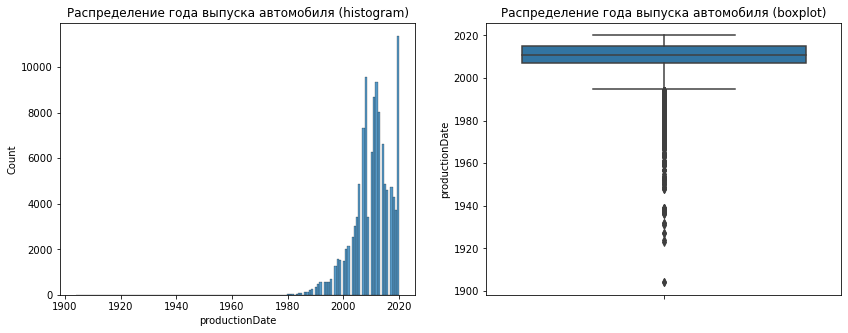

In [129]:
number_graph(all_data, 'productionDate', 'Распределение года выпуска автомобиля')

По результатам графиков получается, что основое количество предлагаемых для продажи автомобилей сосредоточено в диапазоне примерно с 1980 до 2020 года. Все значения ранее 1997 г. формально считаются выбросами. Но если рассмотреть даже самые ранние записи в датасете:

In [130]:
all_data[all_data['productionDate'] < 1930]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
22049,хэтчбек 3 дв.,FORD,синий,бензин,3.3 MT (40 л.с.),HATCHBACK_3_DOORS MECHANICAL 3.3,механическая,3.3 LTR,задний,MODEL_A,...,1927,40.00,5000,1.00,156.00,Левый,Оригинал,0,4500000.00,0
22050,хэтчбек 3 дв.,FORD,чёрный,бензин,3.3 MT (40 л.с.),HATCHBACK_3_DOORS MECHANICAL 3.3,механическая,3.3 LTR,задний,MODEL_A,...,1927,40.00,30000,3.00,163.00,Левый,Оригинал,0,2700000.00,0
22051,кабриолет,FORD,зелёный,бензин,2.9 MT (20 л.с.),CABRIO MECHANICAL 2.9,механическая,2.9 LTR,задний,MODEL_T,...,1923,20.00,1000,1.00,0.00,Левый,Оригинал,0,3800000.00,0
22052,кабриолет,FORD,чёрный,бензин,2.9 MT (20 л.с.),CABRIO MECHANICAL 2.9,механическая,2.9 LTR,задний,MODEL_T,...,1924,20.00,30000,1.00,0.00,Левый,Оригинал,0,3000000.00,0
85567,кабриолет,MERCEDES,белый,бензин,5.3 MT (32 л.с.),CABRIO MECHANICAL 5.3,механическая,5.3 LTR,задний,SIMPLEX,...,1904,32.00,48000,1.00,69.00,Правый,Оригинал,0,12000000.00,0
103798,кабриолет,MERCEDES,белый,бензин,5.3 MT (32 л.с.),CABRIO MECHANICAL 5.3,механическая,5.3 LTR,задний,SIMPLEX,...,1904,32.00,48000,1.00,80.00,Правый,Оригинал,1,0.00,1093802104


можно слелать **вывод**, что отбрасывать полученные выбросы нельзя, т.к. даже в тестовом датасете (см. последнюю строку: *test_data = 1*) присутсвуют раритетные автомобили, которые выставлены на продажу.

***3.5.2.2. Анализ выбросов признака enginePower***

Рассмотрим на предмет выбросов признак *enginePower* (мощность двигателя автомобиля).

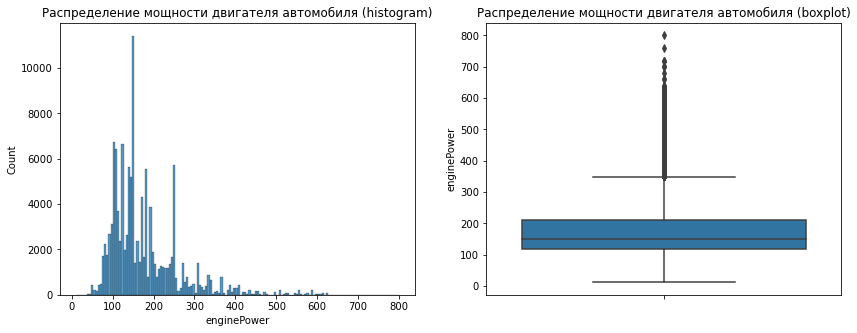

In [131]:
number_graph(all_data, 'enginePower', 'Распределение мощности двигателя автомобиля')

Видно, что и отчет Sweetviz и построеный boxplot, считаю что начиная примерно с уровня мощности в 340-350 л.с. получаются выбросы. Максимальное значение достигает 800 л.с. Если обратиться, например, к ресурсу https://fastmb.ru/autonews/autonews_mir/3661-top-10-moschnyh-dvigateley-legkovyh-avtomobiley.html, то такие значения мощностей даже являются макcимально используемыми для эксклюзивных автомобилей. Поэтому рассмотрим более подробно информацию из сводного датасета для автомобилям с мощностью двигателя свыше 700 л.с.

In [132]:
all_data[all_data['enginePower'] >= 700]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
18118,купе,DODGE,синий,бензин,Hellcat 6.2 AT (717 л.с.),COUPE AUTOMATIC Hellcat,автоматическая,Hellcat LTR,задний,CHALLENGER,...,2016,717.00,5000,1.00,9.00,Левый,Оригинал,0,6500000.00,0
18120,купе,DODGE,серый,бензин,Hellcat 6.2 AT (717 л.с.),COUPE AUTOMATIC Hellcat,автоматическая,Hellcat LTR,задний,CHALLENGER,...,2016,717.00,30000,1.00,0.00,Левый,Оригинал,0,5990000.00,0
18219,пикап,DODGE,серый,бензин,Crew Cab TRX 6.2 AT (702 л.с.) 4WD,PICKUP_TWO AUTOMATIC Crew,автоматическая,Crew LTR,полный,RAM,...,2020,702.00,0,1.00,0.00,Левый,Оригинал,0,14433255.00,0
31525,внедорожник 5 дв.,JEEP,белый,бензин,Trackhawk 6.2 AT (717 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC Trackhawk,автоматическая,Trackhawk LTR,полный,GRAND_CHEROKEE,...,2019,717.00,0,1.00,0.00,Левый,Оригинал,0,10300000.00,0
55641,седан,PORSCHE,серый,электро,Turbo S Electro AT (561 кВт) 4WD,SEDAN AUTOMATIC Turbo,автоматическая,Turbo LTR,полный,TAYCAN,...,2020,761.00,0,1.00,0.00,Левый,Оригинал,0,16601327.00,0
81635,внедорожник 5 дв.,MERCEDES,чёрный,бензин,Brabus 700 4.0 AT (700 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,Brabus LTR,полный,G_KLASSE_AMG,...,2020,700.00,0,1.00,0.00,Левый,Оригинал,0,29300000.00,0
81697,внедорожник 5 дв.,MERCEDES,чёрный,бензин,Brabus 800 4.0 AT (800 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC Brabus,автоматическая,Brabus LTR,полный,G_KLASSE_AMG,...,2020,800.00,0,1.00,0.00,Левый,Оригинал,0,31600000.00,0


Получили список, в который входят мощные внедорожники и суперкары, поэтому заявленная у них мощность двигателя вполне соответсвует реальности.

**Вывод**. Отбрасывать полученные максимальные значения мощности, как выбросы нельзя, т.к. это воплне реальные параметры автомобиля.

***3.5.2.3. Анализ выбросов признака mileage***

Рассмотрим признак *mileage* (заявленный продавцом пробег автомобиля) с позиции выбросов.

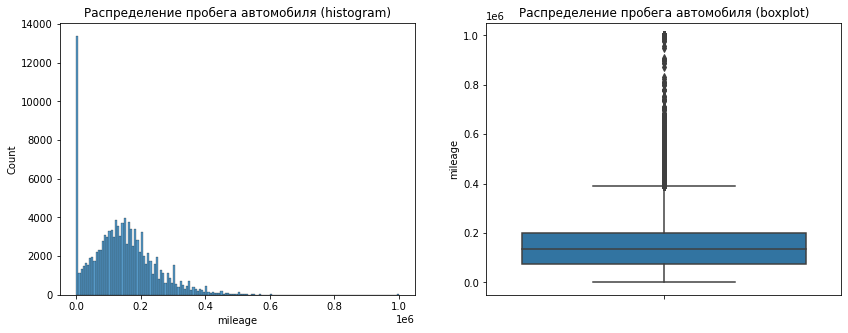

In [133]:
number_graph(all_data, 'mileage', 'Распределение пробега автомобиля')

1. В распределении обнаруживается большое количество записей со значением исследуемого признака раного нулю. При этом, нам известно, что в датасете представлено много предложений новых автомобилей от автосалонов (см. п.3.5.1.3). Исходя из этого можно предположить, что данное значение пробега автомобиля вполне возможно.
2. Максимальное значение пробега автомобия в объединенном датасете составляет 1 000 000 км. Это много, но если обратиться, например, к статье https://auto.mail.ru/article/70819-4-900-000-km-i-drugie-primeryi-rekordnyih-probegov/, то указанные значения можно считать вполне возможными. Рассмотрим более детально "подозрительные" максимальные пробеги  1 000 000  и 999 999 км:

In [134]:
all_data[all_data['mileage'] == 1000000]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
157,седан,AUDI,красный,бензин,1.8 MT (88 л.с.),SEDAN MECHANICAL 1.8,механическая,1.8 LTR,передний,80,...,1987,88.00,1000000,3.00,11.00,Левый,Дубликат,0,40000.00,0
6509,седан,BMW,серый,бензин,520i 2.0 MT (129 л.с.),SEDAN MECHANICAL 520i,механическая,520i LTR,задний,5ER,...,1989,129.00,1000000,3.00,26.00,Левый,Дубликат,0,149000.00,0
7618,седан,BMW,чёрный,бензин,730i 3.0 MT (188 л.с.),SEDAN MECHANICAL 730i,механическая,730i LTR,задний,7ER,...,1989,188.00,1000000,1.00,0.00,Левый,Дубликат,0,160000.00,0
17368,седан,DAEWOO,зелёный,бензин,1.6 MT (109 л.с.),SEDAN MECHANICAL 1.6,механическая,1.6 LTR,передний,NEXIA,...,2009,109.00,1000000,3.00,0.00,Левый,Дубликат,0,75000.00,0
58236,седан,RENAULT,серебристый,бензин,1.4 MT (75 л.с.),SEDAN MECHANICAL 1.4,механическая,1.4 LTR,передний,CLIO_SYMBOL,...,2004,75.00,1000000,3.00,17.00,Левый,Дубликат,0,137000.00,0
64618,купе,TOYOTA,чёрный,бензин,1.6 MT (115 л.с.),COUPE MECHANICAL 1.6,механическая,1.6 LTR,передний,COROLLA_LEVIN,...,1993,115.00,1000000,3.00,0.00,Правый,Дубликат,0,100000.00,0
65489,внедорожник 3 дв.,TOYOTA,белый,дизель,2.5d MT (86 л.с.) 4WD,ALLROAD_3_DOORS MECHANICAL 2.5d,механическая,2.5d LTR,полный,LAND_CRUISER,...,1987,86.00,1000000,3.00,0.00,Левый,Дубликат,0,330000.00,0
65494,внедорожник 5 дв.,TOYOTA,пурпурный,дизель,4.2d AT (165 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC 4.2d,автоматическая,4.2d LTR,полный,LAND_CRUISER,...,1994,165.00,1000000,3.00,44.00,Левый,Дубликат,0,550000.00,0
68895,седан,VOLKSWAGEN,белый,бензин,1.8 MT (90 л.с.),SEDAN MECHANICAL 1.8,механическая,1.8 LTR,передний,JETTA,...,1990,90.00,1000000,2.00,0.00,Левый,Оригинал,0,220000.00,0
74333,фургон,VOLKSWAGEN,белый,бензин,1.9 MT (60 л.с.),VAN MECHANICAL 1.9,механическая,1.9 LTR,задний,TRANSPORTER,...,1983,60.00,1000000,3.00,20.00,Левый,Дубликат,0,200000.00,0


In [135]:
all_data[all_data['mileage'] == 999999]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
2288,седан,AUDI,зелёный,бензин,1.8 AT (150 л.с.),SEDAN AUTOMATIC 1.8,автоматическая,1.8 LTR,передний,A6,...,1998,150.00,999999,3.00,0.00,Левый,Дубликат,0,175000.00,0
4479,седан,BMW,синий,бензин,318i 1.8 MT (102 л.с.),SEDAN MECHANICAL 318i,механическая,318i LTR,задний,3ER,...,1986,102.00,999999,3.00,27.00,Левый,Дубликат,0,60000.00,0
6674,седан,BMW,зелёный,бензин,520i 2.0 MT (150 л.с.),SEDAN MECHANICAL 520i,механическая,520i LTR,задний,5ER,...,1992,150.00,999999,3.00,0.00,Левый,Оригинал,0,120000.00,0
11382,лифтбек,CHERY,бежевый,бензин,1.6 MT (88 л.с.),LIFTBACK MECHANICAL 1.6,механическая,1.6 LTR,передний,AMULET,...,2007,88.00,999999,1.00,0.00,Левый,Оригинал,0,79000.00,0
31858,внедорожник,JEEP,оранжевый,бензин,2.5 MT (121 л.с.) 4WD,ALLROAD_OPEN MECHANICAL 2.5,механическая,2.5 LTR,полный,WRANGLER,...,1992,121.00,999999,3.00,0.00,Левый,Оригинал,0,650000.00,0
41409,компактвэн,MITSUBISHI,чёрный,бензин,2.0 AT (135 л.с.),COMPACTVAN AUTOMATIC 2.0,автоматическая,2.0 LTR,передний,DION,...,2001,135.00,999999,3.00,0.00,Правый,Оригинал,0,230000.00,0
42380,седан,MITSUBISHI,белый,бензин,1.6 MT (98 л.с.),SEDAN MECHANICAL 1.6,механическая,1.6 LTR,передний,LANCER,...,2006,98.00,999999,3.00,85.00,Левый,Дубликат,0,240000.00,0
45502,пикап,NISSAN,белый,дизель,2.3d MT (75 л.с.),PICKUP_ONE MECHANICAL 2.3d,механическая,2.3d LTR,задний,DATSUN,...,1987,75.00,999999,3.00,0.00,Правый,Оригинал,0,120000.00,0
57287,седан,RENAULT,серый,бензин,1.4 MT (75 л.с.),SEDAN MECHANICAL 1.4,механическая,1.4 LTR,передний,LOGAN,...,2007,75.00,999999,3.00,0.00,Левый,Оригинал,0,200000.00,0
68073,хэтчбек 3 дв.,VOLKSWAGEN,серый,бензин,1.8 MT (136 л.с.),HATCHBACK_3_DOORS MECHANICAL 1.8,механическая,1.8 LTR,передний,CORRADO,...,1992,136.00,999999,3.00,0.00,Левый,Оригинал,0,350000.00,0


**Вывод**. Сами значения "10000000" и "9999" похожи на формальное заполнение реквизита в форме ввода, при отсутвии достоверных данных. Реальность этих значений, так же иногда вызывает сомения по отношению к году выпуска автомобиля. Но с учетом того, что данные значения присутствуют как в тренировочном, так и в тестовом дататсете (см. значения признака *test_data*), оставим их для использования в модели.

***3.5.2.4. Анализ выбросов признака ВладениеМес***

Рассмотрим распределение признака *ВладениеМес* (срок владения автомобилем пролавцом, в мес.).

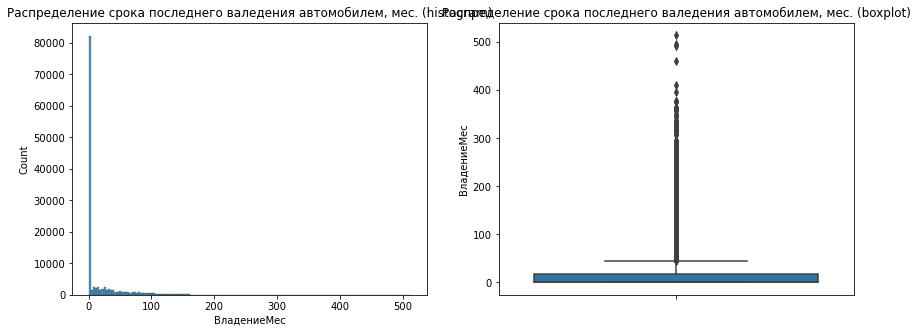

In [136]:
number_graph(all_data, 'ВладениеМес', 'Распределение срока последнего валедения автомобилем, мес.')

В виду того, что в данном датасете присутствует большое количество записей с нулевым значением признака *ВладениеМес* (~2/3 от общего количества записей), то на boxplot'е появляется большое количество выбросов. Проанализируем корректность предложенных значений рассматривамого признака.
1. Нулевое значение данного признака может означать, что данный автомобиль является новым или, что по данному автомобилю не была указана дата и срок владения. Напомню, что данный признак мы получили на основании преобразования признака *Владение* в тестовом и тренировчном датасетах (см. п.3.3.23). Так же стоит отметить, что данный признак в обоих датасетах имел большое количество пропусков и они были заполнены 0 (нулем) в процессе преобразования в признак *ВладениеМес*. В виду неопределенности нулевого значения данного признака пока оставим его в датасете "как есть". В дальнейшем будем учитавть разбалансированность выборки по данному параметру при улучшении модели.
2. Расмотрим несколько топовх записей по рассматриваемому ппризнаку. Возьмем в качестве границы выборки значение - 400 мес. владения автомобиля.

In [137]:
all_data[all_data['ВладениеМес'] >= 400]

,bodyType,brand,color,fuelType,name,vehicleConfiguration,vehicleTransmission,engineDisplacement,Привод,model_name,...,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,sell_id
3867,седан 2 дв.,BMW,оранжевый,бензин,2.0 MT (101 л.с.),SEDAN_2_DOORS MECHANICAL 2.0,механическая,2.0 LTR,задний,02,...,1972,101.00,117000,1.00,497.00,Левый,Оригинал,0,1000000.00,0
52841,седан,OPEL,синий,бензин,1.7 MT (75 л.с.),SEDAN MECHANICAL 1.7,механическая,1.7 LTR,задний,REKORD,...,1969,75.00,300000,3.00,491.00,Левый,Дубликат,0,270000.00,0
55666,хэтчбек 5 дв.,RENAULT,красный,бензин,1.1 MT (45 л.с.),HATCHBACK_5_DOORS MECHANICAL 1.1,механическая,1.1 LTR,передний,6,...,1978,45.00,111111,2.00,460.00,Левый,Оригинал,0,76072.00,0
90028,седан,AUDI,чёрный,бензин,3.3 MT (75 л.с.),SEDAN MECHANICAL 3.3,механическая,3.3 LTR,задний,920,...,1938,75.00,90000,2.00,410.00,Левый,Оригинал,1,0.00,1091525266
95202,седан 2 дв.,BMW,оранжевый,бензин,2.0 MT (101 л.с.),SEDAN_2_DOORS MECHANICAL 2.0,механическая,2.0 LTR,задний,02,...,1972,101.00,117000,1.00,514.00,Левый,Оригинал,1,0.00,1088187706


Видно, что значения признака *ВладениеМес* достаточно неплохо согласуется с годом выпуска автомобиля (*productionDate*) и количеством владельцов (*Владельцы*). Так же можно обратить внимание на то, что рассматриваемые топовые значения присутствуют как в тестовом, так и в тренировочном датасете (см. признак *test_data*). Т.е. мы имеем вполне корректные данные по максимальным значениям.

**Вывод**. Все значения признака *ВладениеМес* не считаем выбросами и будем пытаться использовать для посторения модели. 

***3.5.3. Анализ взаимосвязи признаков***

Анализ взаимосвязи признаков объединного датасета проведем на основании отчета полученного с помощью библиотеки Sweetviz в п.3.5.2. Используем данные из файла *Analysis all_data (clear).html*. Выделим из этого файла таблицу ассоциаций:
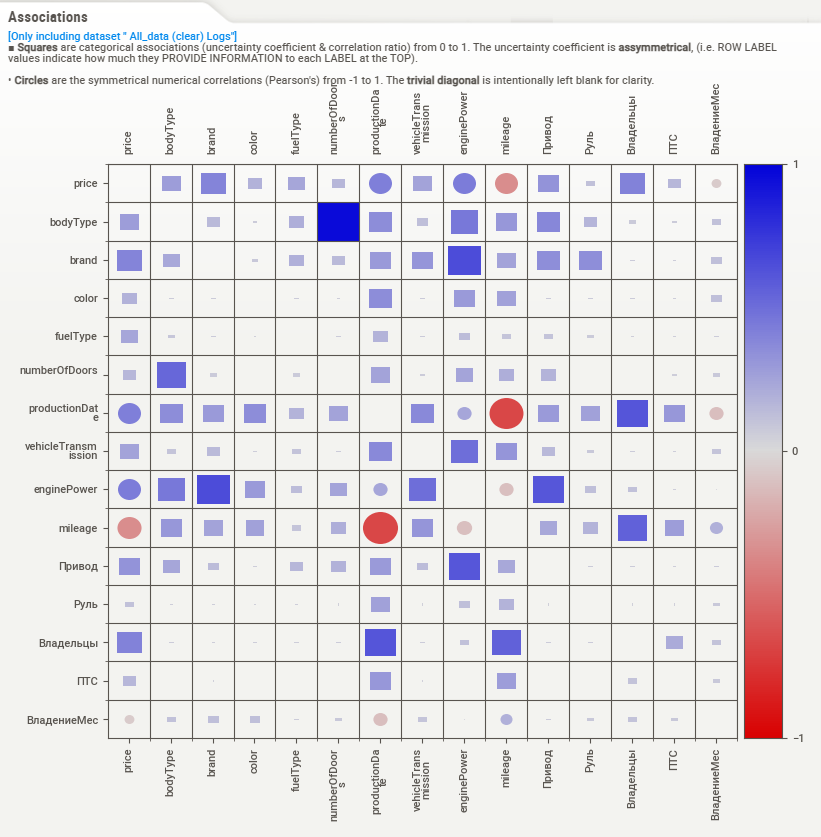

В данной таблице представлены коэффициенты неопределенности и коэффициенты корреляции (от 0 до +1) для категориальных признаков - разноразмерные квадраты. Выделенные нами ранее бинарнарные признаки являются частным случаем категориальных. Кругами в таблице представлена числовая корреляция (от -1 до +1) между числовыми признаками датасета.

Сильно коррелирующие между собой числовые признаки, где коэффициент корреляции близок к единице, были обработаны еще в процессе формировании отчета, из которого взята данная таблица (см. 3.5.2). В оставшихся взаимосвязях признаков между собой можно отметить досточно высокую обрантую кореляцию между числовыми признаками *productionDate* и *mileage*, что досаточно логично: при увеличении возраста автомобиля, при его обычной эксплуатации, увеличивается и его пробег, а так же высокий коэффициент связи между категориальными признаками *bodyType* и *numberOfDoors*. Последняя зависимость объясняется тем, что достатчно часто тип кузова автомобиля определяет количество дверей в нем, а так же то, что число дверей в некоторый типах кузовов явно включено в их название в нашем датасете.

Если рассматривать взаимосвязь выбрабранных из датасета признаков с целевым признаком *price*, то можно отметить что все эти признаки обладают достаточными коэффициентами неопределенности и коэффициентами корреляции для использования в модели. Признаки, оказывающие преобладающее значение: бренд, год выпуска автомобиля, мощность двигателя, пробег и количество владельцев. Минимальное влияние на цену оказывает расположение руля, что не удивляет, зная соотношение этого признака в исследуемом датасете - 97/3.

**Вывод**. Анализ взаимосвязи признаков показал, что почти все выбранные по результатам обработки данных признаки подходят для использования в модели. Найденные сильно коррелирующие признаки были удалены. Выделены признаки, которые оказывают наибольшее влияние на целевой признак цены. На основании этих данных, а также замечаний, который были сделаны по результатм обработки конктрентых признаков датасета, в перспективе можно будет преобразовывать имеющиеся или проектировать новые признаки для улучшения качества модели.

***3.5.4. Обработка признаков для использования в модели***

Для использования всех вышеуказанных признаков в ML-модели, необходимо привести их к числовым значениям. В зависимости от категории/группы признаков необходимо использовать различные методы преобразования. Проведем необходимые преобразования признаков для получения требуемого их представления для модели.

***3.5.4.1. Преобразования бинарных признаков***

При первичной обработке признаков (см. п.3.3) были выделены следующие бинарные признаки:

In [138]:
bin_cols

['Руль', 'ПТС']

Для кодирования признаков данного типа удобно использовать LabelEncoder. Выполним данное преобразование.

In [139]:
label_encoder = LabelEncoder()
for column in bin_cols:
    all_data[column] = label_encoder.fit_transform(all_data[column])
    print(all_data[column].value_counts()) # Проверим результат 

0    118365
1      3175
Name: Руль, dtype: int64
1    106646
0     14894
Name: ПТС, dtype: int64


***3.5.4.2. Преобразования категориальных признаков***

Как категориальные ранее были определены следующие признаки:

In [140]:
cat_cols

['bodyType',
 'brand',
 'color',
 'fuelType',
 'name',
 'vehicleConfiguration',
 'vehicleTransmission',
 'engineDisplacement',
 'Привод',
 'model_name']

В зависимости от количества различных значений категориальных признаков (см. файл *Analysis all_data (clear).html*) воспользуемся различными видами кодировщиков. 

Для признака *Привод*, имеющего 3 различных значения используем dummy-кодирование pandas:

In [141]:
all_data = pd.get_dummies(all_data, columns=['Привод'])

Для признаков *vehicleTransmission* (4 уникальных значения) и *fuelType* (5 уникальных значений) воспользуемся бинарным кодировщиком (BinaryEncoder) из библиотеки *category_encoders*:

In [142]:
bin_encoder = ce.BinaryEncoder(cols=['vehicleTransmission', 'fuelType'])
df_bin = bin_encoder.fit_transform(all_data[['vehicleTransmission','fuelType']])
all_data = pd.concat([all_data, df_bin], axis=1)
all_data.drop(['vehicleTransmission','fuelType'], axis=1, inplace=True)

Остальные категориальные признаки, в виду большого количества уникальных значений в них преобразуем с помощью целевого по цене кодировщика (TargetEncoder) из той же библиотеки category_encoders:

In [143]:
te_encoder = ce.TargetEncoder()
df_te = te_encoder.fit_transform(all_data[['bodyType','brand', 'color', 'name', 'vehicleConfiguration', 'engineDisplacement', 'model_name']], all_data['price'])
all_data.drop(['bodyType','brand', 'color', 'name', 'vehicleConfiguration', 'engineDisplacement', 'model_name'], axis=1, inplace=True)
all_data = pd.concat([all_data, df_te], axis=1)

Проверим изменение структуры колонок и содержмиое объединенного датасета, после преобразований категориальных признаков:

In [144]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121540 entries, 0 to 121539
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   numberOfDoors          121540 non-null  float64
 1   productionDate         121540 non-null  int64  
 2   enginePower            121540 non-null  float64
 3   mileage                121540 non-null  int64  
 4   Владельцы              121540 non-null  float64
 5   ВладениеМес            121540 non-null  float64
 6   Руль                   121540 non-null  int32  
 7   ПТС                    121540 non-null  int32  
 8   test_data              121540 non-null  int64  
 9   price                  121540 non-null  float64
 10  sell_id                121540 non-null  int64  
 11  Привод_задний          121540 non-null  uint8  
 12  Привод_передний        121540 non-null  uint8  
 13  Привод_полный          121540 non-null  uint8  
 14  vehicleTransmission_0  121540 non-nu

In [145]:
all_data.head()

,numberOfDoors,productionDate,enginePower,mileage,Владельцы,ВладениеМес,Руль,ПТС,test_data,price,...,fuelType_0,fuelType_1,fuelType_2,bodyType,brand,color,name,vehicleConfiguration,engineDisplacement,model_name
0,4.00,1991,174.00,350000,3.00,0.00,0,1,0,200000.00,...,0,0,1,682269.38,748531.21,1171024.70,119620.19,121460.32,249169.26,63032.40
1,4.00,1986,90.00,173424,3.00,0.00,0,1,0,60000.00,...,0,0,1,682269.38,748531.21,602894.41,53600.45,186371.56,259698.68,63032.40
2,5.00,1989,136.00,230000,3.00,0.00,0,1,0,99000.00,...,0,0,1,387646.51,748531.21,922167.14,901049.04,109590.91,392039.84,63032.40
3,4.00,1989,90.00,240000,3.00,0.00,0,1,0,65000.00,...,0,0,1,682269.38,748531.21,503632.65,53600.45,186371.56,259698.68,63032.40
4,4.00,1991,101.00,300000,3.00,0.00,0,0,0,100000.00,...,0,0,1,682269.38,748531.21,1171024.70,101809.53,221944.09,745403.34,63032.40


Видно, что все изначально выбранные категориальные переменные пременные преобразованы в цисловые значения.

***3.5.4.3. Преобразования пограничных признаков***

Рассмотрим признаки, которые ранее нами были отнесены к числовым:

In [146]:
num_cols

['numberOfDoors',
 'productionDate',
 'enginePower',
 'mileage',
 'Владельцы',
 'ВладениеМес']

Из этого списка есть два признака, которые отчет Sweetviz (см. файл *Analysis all_data (clear).html*) отнес к категориальным признакам. Это *numberOfDoors* (количество дверей в автомобиле) и *Владельцы* (количество владельцев автомобилем). Рассмотрим их более внимательно.

Признак *numberOfDoors* (количество дверей в автомобиле):

In [147]:
all_data['numberOfDoors'].value_counts()

5.00    68664
4.00    46958
2.00     3077
3.00     2839
0.00        2
Name: numberOfDoors, dtype: int64

Видно, что по своей сути - это классификатор автомобиля по количеству дверей в нем. С другой стороны - это количественная оценка одной из характеристик автомобиля. Данный параметр был приведен к числовому типу еще на этапе предобработки данных и сейчас может использоваться в модели без дополнительных преобразований.

Признак *Владельцы* (количество владельцев автомобилем):

In [148]:
all_data['Владельцы'].value_counts()

3.00    51819
1.00    39688
2.00    30033
Name: Владельцы, dtype: int64

Аналогично предыдущему рассмотреному признаку, данный признак может рассматриваться как категориальный, так и как числовой. Это позволяет использовать его в модели, в том виде который мы получили в процессе предобработки данных.

***3.5.4.4. Преобразования числовых признаков***

Рассмотрим оставшиеся числовые признаки, выведенные в предыдущем пункте (см. п.3.5.4.3).

In [149]:
all_data['productionDate'].describe()

count   121540.00
mean      2010.27
std          7.03
min       1904.00
25%       2007.00
50%       2011.00
75%       2015.00
max       2020.00
Name: productionDate, dtype: float64

Видно, что признак *productionDate* (год выпуска автомобиля) имеет диапазон целочисленных значений от 1904 до 2020. Для улучшения качества создаваемой модели проведем стандартизацию данного признака.

In [150]:
all_data['enginePower'].describe()

count   121540.00
mean       175.83
std         85.57
min         11.00
25%        117.00
50%        150.00
75%        210.00
max        800.00
Name: enginePower, dtype: float64

Разброс значений признака *enginePower* (мощность двигателя) - от 11 до 800. Так же проведем стандартизацию.

In [151]:
all_data['mileage'].describe()

count    121540.00
mean     144302.00
std      102518.73
min           0.00
25%       72909.00
50%      137000.00
75%      200000.00
max     1000000.00
Name: mileage, dtype: float64

Разброс значений признака *mileage* (пробег автомобиля) - от 0 до 1000000. Требуется проведение стандартизации.

In [152]:
all_data['ВладениеМес'].describe()

count   121540.00
mean        16.74
std         34.29
min          0.00
25%          0.00
50%          0.00
75%         18.00
max        514.00
Name: ВладениеМес, dtype: float64

Разброс значений признака *ВладениеМес* (срок последнего владения автомобилем в мес.) - от 0 до 514. Требуется проведение стандартизации. Проведем ее для всех указанных признаков одновременно:

In [153]:
lst_cols = ['productionDate','enginePower', 'mileage', 'ВладениеМес']
scaler = StandardScaler()
for col in lst_cols:
    sc = scaler.fit_transform(all_data[col].values.reshape(-1, 1))
    df_sc = pd.DataFrame(sc, columns=[col])
    all_data.drop([col], axis=1, inplace=True)
    all_data = pd.concat([all_data, df_sc], axis=1)

In [154]:
all_data

,numberOfDoors,Владельцы,Руль,ПТС,test_data,price,sell_id,Привод_задний,Привод_передний,Привод_полный,...,brand,color,name,vehicleConfiguration,engineDisplacement,model_name,productionDate,enginePower,mileage,ВладениеМес
0,4.00,3.00,0,1,0,200000.00,0,0,0,1,...,748531.21,1171024.70,119620.19,121460.32,249169.26,63032.40,-2.74,-0.02,2.01,-0.49
1,4.00,3.00,0,1,0,60000.00,0,0,1,0,...,748531.21,602894.41,53600.45,186371.56,259698.68,63032.40,-3.45,-1.00,0.28,-0.49
2,5.00,3.00,0,1,0,99000.00,0,0,0,1,...,748531.21,922167.14,901049.04,109590.91,392039.84,63032.40,-3.02,-0.47,0.84,-0.49
3,4.00,3.00,0,1,0,65000.00,0,0,1,0,...,748531.21,503632.65,53600.45,186371.56,259698.68,63032.40,-3.02,-1.00,0.93,-0.49
4,4.00,3.00,0,0,0,100000.00,0,0,1,0,...,748531.21,1171024.70,101809.53,221944.09,745403.34,63032.40,-2.74,-0.87,1.52,-0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121535,4.00,3.00,0,1,1,0.00,1101369263,1,0,0,...,1436049.55,942898.86,461911.75,471045.15,396067.62,1114799.91,0.53,-0.47,-0.29,0.24
121536,4.00,1.00,0,1,1,0.00,1101369581,0,0,1,...,1436049.55,1171024.70,2486904.28,494014.60,745403.34,1033302.88,1.10,0.17,-0.45,-0.49
121537,4.00,3.00,0,0,1,0.00,1101364889,1,0,0,...,1436049.55,920506.77,174530.12,550120.57,594891.19,1033302.88,-1.89,-0.07,2.10,-0.49
121538,5.00,2.00,0,1,1,0.00,1101362518,0,0,1,...,1436049.55,942898.86,434525.00,1086871.93,745403.34,1361555.88,0.39,0.10,-0.52,-0.49


In [155]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121540 entries, 0 to 121539
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   numberOfDoors          121540 non-null  float64
 1   Владельцы              121540 non-null  float64
 2   Руль                   121540 non-null  int32  
 3   ПТС                    121540 non-null  int32  
 4   test_data              121540 non-null  int64  
 5   price                  121540 non-null  float64
 6   sell_id                121540 non-null  int64  
 7   Привод_задний          121540 non-null  uint8  
 8   Привод_передний        121540 non-null  uint8  
 9   Привод_полный          121540 non-null  uint8  
 10  vehicleTransmission_0  121540 non-null  int64  
 11  vehicleTransmission_1  121540 non-null  int64  
 12  vehicleTransmission_2  121540 non-null  int64  
 13  fuelType_0             121540 non-null  int64  
 14  fuelType_1             121540 non-nu

**Вывод**. Произвели необходимые преобразования всех категориальных признаков объединенного датасета. Использование некоторых видов кодировщиков может быть спорным. Проверим их различное использование на этапе улучшения выбранной модели.

**3.6. Вывод по разделу**

Произведена вся необходимая обработка и подготовка данных для использования в ML-моделях. Можно переходить к этапу моделирования и анализа полученных результатов.

***4. Создание и проверка моделей***
---

Подготовим данные для использование в первичной модели. Разобъем объединенный датасет обратно на тренировочный и тестовый и подготовим датафрейм *train_data* для использования при обучении моделей.

In [156]:
train_data = all_data.query('test_data == 0').drop(['test_data'], axis=1)
test_data = all_data.query('test_data == 1').drop(['test_data'], axis=1)

X = train_data.drop(['sell_id', 'price'], axis=1)
y = train_data['price'] # целевой признак

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

***4.1. Модель № 1 - без использования ML***

Для формирования начальной точки сравнения точности выбираемых моделей по метрике MAPE, создадим "наивную" модель, которая будет предсказывать среднюю цену по модели двигателя (*engineDisplacement*) и она не будет использовать методы машинного обучения.

In [157]:
native_train = X_train.copy()
native_train['price'] = y_train

# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(native_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 74.17%


В виду достаточно большого значения по метрике MAPE для "наивной" модели, ее проверку в Kaggle проводить не будем. Просто зафиксируем в итоговой таблице *results* итоги работы "наивной" модели:

In [158]:
results = pd.DataFrame(data=[['Native', 74.17, np.nan]], index=[0], columns=['Model', 'train', 'test'])
results

,Model,train,test
0,Native,74.17,NaN


**Вывод**. Получили отправную точку сравнения точности по метрике MAPE для следующих исследуемых ML-моделей. Средняя относительная ошибка прогноза по "наивной" модели 74,17%. Это достаточно большая величина, которая лиiний раз показывает, что необходимо искать более продвинутые методы получения прогнозной цены автомобиля.

***4.2. Модель № 2 - CatBoostRegressor***

Т.к. у нас в данных подавляющее большинство признаков категориальные, то воспользуемся рекормендацией из *baseline* этого проекта на *Kaggle*. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. Используем предложенную библиотеку для формирования и анализа 2-ой модели.

Запустим регрессор из данной библиотеки со значениями гиперпараметров по умолчанию. Отключим только предупреждения и установим изначально заданный *random_seed*.

In [159]:
model = CatBoostRegressor(silent=True, random_seed = RANDOM_SEED)
model.fit(X_train, y_train)

In [160]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели CatBoostRegressor (default) по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели CatBoostRegressor (default) по метрике MAPE: 15.77%


Получили более высокую точность чем у "наивной" модели (модель №1). Попробуем использовать указанные в *baseline* настройки гиперпараметров для данной модели:

In [161]:
model = CatBoostRegressor(iterations = 5000,
                           random_seed = RANDOM_SEED,
                           eval_metric='MAPE',
                           custom_metric=['R2', 'MAE'],
                           silent=True,
                          )
model.fit(X_train, y_train,
          #cat_features=cat_features_ids,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          #plot=True
          )

In [162]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели CatBoostRegressor (tune) по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели CatBoostRegressor (tune) по метрике MAPE: 14.39%


Видно, что указание гиперпараметров из *baseline* привело к дополнительному возрастанию точности модели. 

Использум информацию из п.3.3.25. для проверки предположения того, что логарифмирование цены (целевого признака) улучшит результирующую точность моделей. Для этого добавим в предыдущую модель логарифмирование целевого ппризнака при обучении и обратное преобразование при предсказании:

In [163]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [164]:
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(X_sub))
print(f"Точность модели CatBoostRegressor (tune+log) по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели CatBoostRegressor (tune+log) по метрике MAPE: 12.72%


Точность модели, как мы и предполагали еще возрасла. Пробуем проверить результаты работы этой модели в Liderboard *Kaggle*:

In [165]:
predict_submission = np.exp(model.predict(test_data))
submission['price'] = predict_submission
submission.to_csv(f'submission_CatBooost.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,616952.82
1,1100549428,821891.76
2,1100658222,850682.12
3,1100937408,716872.00
4,1101037972,678072.92
5,1100912634,736073.05
6,1101228730,625145.54
7,1100165896,386786.34
8,1100768262,1742341.26
9,1101218501,812359.52


После отправки полученного файла в Liderboard Kaggle получили его точность 15,02%. Большая разница в ошибке может указывать на то, что тестовый и тренировочный датасеты имеют принципиальные различия по выборке. Занесем результаты в таблицу для сравнения точности моделей и продложим исследование.

In [166]:
results = results.append({'Model':'CatBoostRegressor', 'train':12.72, 'test':15.02}, ignore_index=True)
results

,Model,train,test
0,Native,74.17,NaN
1,CatBoostRegressor,12.72,15.02


**Вывод**. Использование модели CatBoost значительно улучшило точность предсказания цены автомобиля на тренировочном датасете, но значения полученные на тестовом датасете получились хуже, чем на тренировочном. Рассматриваем другие модели.

***4.3. Групповой анализ моделей для выбора лучших для нашего случая***

Для первичного определения наилучших моделей для нашего случая, воспользуемся библиотекой *Lazy Predict* для быстрого анализа и получения сравнителных результатов по моделям. Далее выберем несколько лучших и продолжим их более глубокую проработку.

In [167]:
# Заремаркировано для ускорения пересчета на тестах
#clf = LazyRegressor(verbose=0,
#                     ignore_warnings=True,
#                     custom_metric=None)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#models

Первое на что стоит обратить внимание, что в списке проверенных моделей со значениями гиперпараметров по умочланию, отсутствует рассмотренная в предыдущем пункте модель CatBoost. В текущей версии *Lazy Predict* эта библиотека отключена. Но мы ее рассмотрели отдельно, и можем сопоставлять ее точность с другими моделями доступными в библиотеке *Lazy Predict* на основании наших расчетов.

Второе, мертики, которыми оперирует *Lazy Predict* не сопоставимы с нужной нам метрикой MAPE. Анализ параметров *Lazy Predict* говорит о том, что нужной нам метрики он не поддерживает. Требуется самостоятельно провести расчет нужной нам метрики для заитересовавших нас моделей.

Выделим Топ-10 моделей, полученных после работы библиотеки *Lazy Predict* на наших данных:
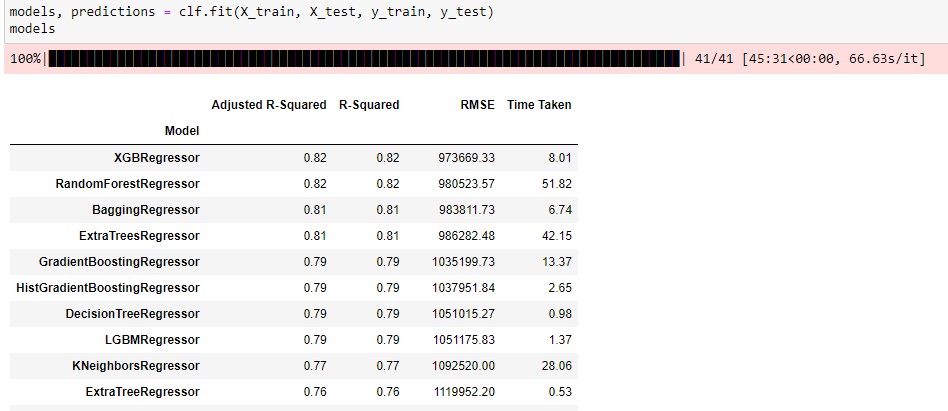

Создадим свою функцию для получения метрики MAPE по выбранным моделям (*test_regressor_mape()*) и расчитаем результаты. Гиперпараметры будем использовать по умолчанию, только зафиксируем нужный нам random_state. 

In [168]:
model_list = ['XGBRegressor', 
           'RandomForestRegressor', 
           'BaggingRegressor', 
           'ExtraTreesRegressor' , 
           'GradientBoostingRegressor',
           'HistGradientBoostingRegressor', 
           'DecisionTreeRegressor', 
           'LGBMRegressor', 
           'KNeighborsRegressor', 
           'ExtraTreeRegressor']

for model_name in model_list:
    test_regressor_mape(model_name, X_train, y_train, y_test)

Точность модели XGBRegressor по метрике MAPE: 15.79%
Точность модели RandomForestRegressor по метрике MAPE: 14.45%
Точность модели BaggingRegressor по метрике MAPE: 15.20%
Точность модели ExtraTreesRegressor по метрике MAPE: 14.82%
Точность модели GradientBoostingRegressor по метрике MAPE: 26.78%
Точность модели HistGradientBoostingRegressor по метрике MAPE: 19.53%
Точность модели DecisionTreeRegressor по метрике MAPE: 19.19%
Точность модели LGBMRegressor по метрике MAPE: 18.96%
Точность модели KNeighborsRegressor по метрике MAPE: 23.18%
Точность модели ExtraTreeRegressor по метрике MAPE: 20.21%


Видно, что по метрике MAPE фавориты немного изменились, но общие тенедеции полученные из *Lazy Predict* остались не изменными. Так же как и в случае, модели СatBoostRegressor проверим как изменится точность при логарифмировании целевого признака.

In [169]:
for model_name in model_list:
    test_regressor_mape(model_name, X_train, y_train, y_test, log=True)

Точность модели XGBRegressor по метрике MAPE: 13.80%
Точность модели RandomForestRegressor по метрике MAPE: 13.59%
Точность модели BaggingRegressor по метрике MAPE: 14.27%
Точность модели ExtraTreesRegressor по метрике MAPE: 13.76%
Точность модели GradientBoostingRegressor по метрике MAPE: 18.83%
Точность модели HistGradientBoostingRegressor по метрике MAPE: 15.07%
Точность модели DecisionTreeRegressor по метрике MAPE: 18.89%
Точность модели LGBMRegressor по метрике MAPE: 15.03%
Точность модели KNeighborsRegressor по метрике MAPE: 21.83%
Точность модели ExtraTreeRegressor по метрике MAPE: 19.72%


Использование логарифмирования цены дейтвительно привело к повышению точности по всем рассмотренным моделям. Подтвердилось утверждение сделанное при анализе целевого признака(п.3.3.25), что логарифмирование должно улучшить работу моделей.

**Вывод**. На основании экспресс-исследования проведенного по множеству различных моделей, остановим свой выбор на трех, давших наименьшие значения метрики MAPE: *RandomForestRegressor*, *ExtraTreesRegressor* и *XGBRegressor*. Проведем более глубокую настроку данных моделей. Следует обратить внимание, что первые две из выбранных моделей являются по времени исполнения самыми медленными.

***4.4. Модель № 3 - RandomForestRegressor***

Для сравнения изменения результатов работы модели RandomForestRegressor при изменении ее параметров, зафиксируем начальную точность модели.

In [170]:
model = RandomForestRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
predict = np.exp(model.predict(X_test))
print(f"Точность модели RandomForestRegressor(log) по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели RandomForestRegressor(log) по метрике MAPE: 13.59%


Проверим, какова точность этой модели на тестовых данных в Kaggle:

In [171]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_RandomForestDefault.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,594702.63
1,1100549428,892815.86
2,1100658222,867716.68
3,1100937408,703766.81
4,1101037972,702041.84
5,1100912634,714232.48
6,1101228730,572693.02
7,1100165896,448791.32
8,1100768262,1220225.68
9,1101218501,716577.88


После отправки файла *submission* в Leaderboard Kaggle, получили следующий результат - 18,02%. Точность стала меньше. Это может быть связано с переобучением модели. Проверим модель используя кросс-валидацию.

In [172]:
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
mape_values = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    model.fit(X_train, np.log(y_train))

    y_pred = np.exp(model.predict(X_test))

    mape_value = mape(y_test, y_pred)
    mape_values.append(mape_value)
    print(f"Промежуточное значение MAPE метрики: {(mape_value * 100):0.2f}%.")

print(f"Итоговое значение MAPE метрики (на 5 выборках): {(np.mean(mape_values) * 100):0.2f}%.")

Промежуточное значение MAPE метрики: 13.60%.
Промежуточное значение MAPE метрики: 13.54%.
Промежуточное значение MAPE метрики: 13.37%.
Промежуточное значение MAPE метрики: 13.24%.
Промежуточное значение MAPE метрики: 13.41%.
Итоговое значение MAPE метрики (на 5 выборках): 13.43%.


Получили, что значение метрики по кросс-валидации близко к значению полученному при обучении модели с настройками по умолчанию. Т.е., это не похоже на переобучение модели. Возможно, что данные в тренировочном датасете могли уже устареть и их нужно обновлять исходя их данных тестовой выборки.

Попробуем улучшить качество модели, пытаясь подобрать наилучшие гиперпараметры для исследуемой модели. Используем для этого библиотеку *Hyperopt*.

In [173]:
def objective(params):
    model=RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        n_jobs=-1,
        random_state=RANDOM_SEED)
    model.fit(X_train, np.log(y_train))
    return mape(y_test, np.exp(model.predict(X_test)))

def optimize(trial):
    params={
        'n_estimators': hp.uniform('n_estimators', 10, 500),
        'max_depth': hp.uniform('max_depth', 1, 50),
        'min_samples_split': hp.uniform('min_samples_split', 2, 10),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 10),
        'max_features': hp.choice("max_features", ['auto', 'sqrt', 'log2']),
        'bootstrap': hp.choice("bootstrap", [True, False])
    }
    return fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, show_progressbar=True)

# Заремаркировано для ускорения пересчета на тестах
#trial = Trials()
#print(optimize(trial))

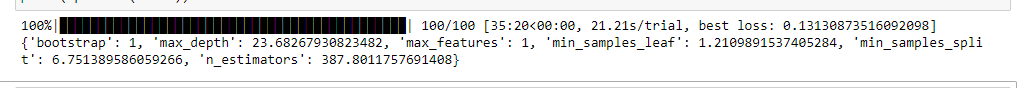

Применим в модели полученные гиперпараметры:

In [174]:
model = RandomForestRegressor(random_state=RANDOM_SEED,
                             n_jobs=-1,
                             bootstrap=True,
                             max_depth=24,
                             max_features = 'auto',
                             min_samples_leaf=1,
                             min_samples_split=7,
                             n_estimators=387)
model.fit(X_train, np.log(y_train))

RandomForestRegressor(max_depth=24, min_samples_split=7, n_estimators=387,
                      n_jobs=-1, random_state=42)

In [175]:
# оцениваем точность
predict = np.exp(model.predict(X_test))
print(f"Точность модели RandomForestRegressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели RandomForestRegressor по метрике MAPE: 13.25%


Получили незначительное улучшение точности. При этом, точность остается соизмеримой со значениями полученными в модели с гиперпараметрами по умолчанию и провернными через кросс-валидацию. Отправляем результаты работы модели на тестовой выборке в Leaderboard Kaggle для проверки.

In [176]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_RandomForestTune.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,593316.48
1,1100549428,913198.66
2,1100658222,829961.90
3,1100937408,707310.70
4,1101037972,642142.48
5,1100912634,774053.77
6,1101228730,594321.30
7,1100165896,392844.41
8,1100768262,1221245.65
9,1101218501,680561.55


Результат полученный в Leaderboard Kaggle - 18,32%. Точность на Kaggle заметно немного хуже. Фиксируем лучший результат работы модели в Leaderboard Kaggle в итоговой таблице:

In [177]:
results = results.append({'Model':'RandomForestRegressor', 'train':13.59, 'test':18.02}, ignore_index=True)
results

,Model,train,test
0,Native,74.17,NaN
1,CatBoostRegressor,12.72,15.02
2,RandomForestRegressor,13.59,18.02


**Вывод**. Нам не удалось улучшить параметры модели RandomForestRegressor по сравнению с моделью СatBoostRegressor. Кроме этого работа исследуемой модели на тестовой выборке приводит к большему падению точности, чем в модели CatBoostRegressor. Продолжаем исследовать другие выбранные модели.

***4.5. Модель № 4 - ExtraTreesRegressor***

Проанализируем работу модели ExtraTreesRegressor на тренировочном и тестовом датасете в режиме настроек гиперпараметров "по умолчанию".

In [178]:
model = ExtraTreesRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
predict = np.exp(model.predict(X_test))
print(f"Точность модели ExtraTreesRegressor(log) по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели ExtraTreesRegressor(log) по метрике MAPE: 13.73%


In [179]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_ExtraTreesDefault.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,606389.14
1,1100549428,874402.32
2,1100658222,746380.87
3,1100937408,652366.30
4,1101037972,702450.65
5,1100912634,776088.43
6,1101228730,571369.57
7,1100165896,365000.00
8,1100768262,1137076.50
9,1101218501,556744.87


В Leaderboard Kaggle по результатам работы данной модели получено значение MAPE - 15,75%. Это много лучше, чем у предудущей модели, но немного хуже чем у модели СatBoostRegressor.

Как и в случае модели RandomForestRegressor, проверим исследуемую модель методом кросс-валидации.

In [180]:
model = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)

skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
mape_values = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    model.fit(X_train, np.log(y_train))

    y_pred = np.exp(model.predict(X_test))

    mape_value = mape(y_test, y_pred)
    mape_values.append(mape_value)
    print(f"Промежуточное значение MAPE метрики: {(mape_value * 100):0.2f}%.")

print(f"Итоговое значение MAPE метрики (на 5 выборках): {(np.mean(mape_values) * 100):0.2f}%.")

Промежуточное значение MAPE метрики: 13.78%.
Промежуточное значение MAPE метрики: 13.76%.
Промежуточное значение MAPE метрики: 13.77%.
Промежуточное значение MAPE метрики: 13.56%.
Промежуточное значение MAPE метрики: 13.73%.
Итоговое значение MAPE метрики (на 5 выборках): 13.72%.


Видно, что значение MAPE, полученное методом кросс-валидации практически не отличается от этого значения полученного на модели с гиперпараметрами по умолчанию. Можно констатировать получение устойчивого результата на различных частях данных тренировочного датасета.

Попробуем увеличить точность модели с помощью подбора гиперпараметров. Используем ту же технологию, что и в прошлой модели - библиотеку *Hyperopt*:

In [181]:
def objective(params):
    model=ExtraTreesRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        n_jobs=-1,
        random_state=RANDOM_SEED)
    model.fit(X_train, np.log(y_train))
    return mape(y_test, np.exp(model.predict(X_test)))

def optimize(trial):
    params={
        'n_estimators': hp.uniform('n_estimators', 10, 500),
        'max_depth': hp.uniform('max_depth', 1, 50),
        'min_samples_split': hp.uniform('min_samples_split', 2, 10),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 1, 10),
        'max_features': hp.choice("max_features", ['auto', 'sqrt', 'log2']),
        'bootstrap': hp.choice("bootstrap", [True, False])
    }
    return fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, show_progressbar=True)

# Заремаркировано для ускорения пересчета на тестах
#trial = Trials()
#print(optimize(trial))

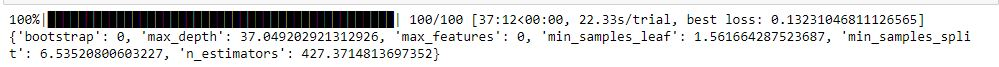

Применим в модели полученные гиперпараметры:

In [182]:
model = ExtraTreesRegressor(random_state=RANDOM_SEED,
                            n_jobs=-1,
                            bootstrap=True,
                            max_depth=37,
                            max_features = 'auto',
                            min_samples_leaf=2,
                            min_samples_split=7,
                            n_estimators=427)
model.fit(X_train, np.log(y_train))

predict = np.exp(model.predict(X_test))
print(f"Точность модели ExtraTreesRegressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели ExtraTreesRegressor по метрике MAPE: 13.36%


Точность незначительно улучшлась, но осталась соизмеримой со значениями полученными в модели с гиперпараметрами по умолчанию и провернными через кросс-валидацию. Отправляем результаты в Leaderboard Kaggle для проверки.

In [183]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_ExtraTreesTune.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,598837.86
1,1100549428,843520.37
2,1100658222,750003.49
3,1100937408,633367.68
4,1101037972,661187.38
5,1100912634,777234.51
6,1101228730,600074.95
7,1100165896,383456.90
8,1100768262,1116773.44
9,1101218501,570862.32


После загрузки в Leaderboard Kaggle результатов работы данной модели, получено значение MAPE = 17,53%. Это значение хуже, чем у этой же модели с параметрами по умолчанию. Подбор оптимальных для тренировочного датасета параметров не привел к улучшению показателелей на тестовом датасете. Занесем лучший результат работы этой модели в Leaderboard Kaggle в итоговую таблицу:

In [184]:
results = results.append({'Model':'ExtraTreesRegressor', 'train':13.73, 'test':15.75}, ignore_index=True)
results

,Model,train,test
0,Native,74.17,NaN
1,CatBoostRegressor,12.72,15.02
2,RandomForestRegressor,13.59,18.02
3,ExtraTreesRegressor,13.73,15.75


**Вывод**. Нам не удалось улучшить параметры модели ExtraTreesRegressor по сравнению с параметрами по умолчанию. При этом данная модель показала на тестовом датасете соизмеримую с лучшей на данный момент моделью CatBoostRegressor точность.

***4.6. Модель № 5 - XGBRegressor***

Рассмотрим оценку модели XGBRegressor с настройками гиперпараметров "по умолчанию" на тренировочном и тестовом датасетах.

In [185]:
model = XGBRegressor(random_state=RANDOM_SEED)
model.fit(X_train, np.log(y_train))
predict = np.exp(model.predict(X_test))
print(f"Точность модели XGBRegressor(log) по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели XGBRegressor(log) по метрике MAPE: 13.73%


In [186]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_XGBDefault.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,568236.94
1,1100549428,822040.56
2,1100658222,897339.50
3,1100937408,766362.69
4,1101037972,685234.38
5,1100912634,711553.19
6,1101228730,604292.94
7,1100165896,384338.03
8,1100768262,1620500.25
9,1101218501,753019.25


В Leaderboard Kaggle по результатам работы данной модели получено значение метрики MAPE - 16,92%. Это точность ниже, чем у рассмотернных ранее моделей CatBoostRegressor и ExtraTreesRegressor, но выше чем у модели RandomForestRegressor.

Проверим модель XGBRegressor методом кросс-валидации.

In [187]:
model = XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1)

skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
mape_values = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    model.fit(X_train, np.log(y_train))

    y_pred = np.exp(model.predict(X_test))

    mape_value = mape(y_test, y_pred)
    mape_values.append(mape_value)
    print(f"Промежуточное значение MAPE метрики: {(mape_value * 100):0.2f}%.")

print(f"Итоговое значение MAPE метрики (на 5 выборках): {(np.mean(mape_values) * 100):0.2f}%.")

Промежуточное значение MAPE метрики: 13.80%.
Промежуточное значение MAPE метрики: 14.10%.
Промежуточное значение MAPE метрики: 13.82%.
Промежуточное значение MAPE метрики: 13.67%.
Промежуточное значение MAPE метрики: 13.73%.
Итоговое значение MAPE метрики (на 5 выборках): 13.82%.


Значение точности полученное после кросс-валидации немного больше, чем полученное ранее. Видно, что кросс-валидация выдает результат точности практически без значительных отклонений на всех выборках, что говорит об однородности данных в тренировочном датасете.

Подберем нилучшие гиперпараметры исследуемой модели, аналогично предыдущим моделям:

In [188]:
def objective(params):
    model=XGBRegressor(
        objective='reg:squarederror',
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        colsample_bytree=int(params['colsample_bytree']),
        learning_rate=int(params['learning_rate']),
        alpha=params['alpha'],
        n_jobs=-1,
        random_state=RANDOM_SEED)
    model.fit(X_train, np.log(y_train))
    return mape(y_test, np.exp(model.predict(X_test)))

def optimize(trial):
    params={
        'n_estimators': hp.uniform('n_estimators', 1, 1000),
        'max_depth': hp.uniform('max_depth', 1, 50),
        'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.1),
        'learning_rate': hp.quniform('learning_rate', 0, 1, 0.01),
        'alpha': hp.choice("alpha", [0, 1])
    }
    return fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, show_progressbar=True)

# Заремаркировано для ускорения пересчета на тестах
#trial = Trials()
#print(optimize(trial))

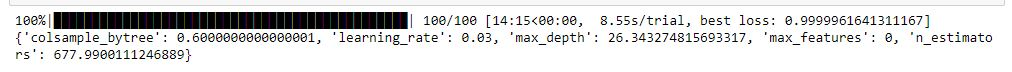

In [189]:
model = XGBRegressor(
     objective='reg:squarederror', 
     colsample_bytree=0.6,               
     learning_rate=0.03, 
     max_depth=26, 
     alpha=1,                   
     n_estimators=678,
     random_state=RANDOM_SEED,
     n_jobs=-1)
model.fit(X_train, np.log(y_train))
predict = np.exp(model.predict(X_test))
print(f"Точность модели XGBRegressor по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели XGBRegressor по метрике MAPE: 12.53%


Точность модели улучшлась более чем на 1%, посмотрим как это отразилось в Leaderboard Kaggle:

In [190]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_XGBTune.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,615345.31
1,1100549428,882986.19
2,1100658222,849757.38
3,1100937408,719976.44
4,1101037972,680026.38
5,1100912634,818643.62
6,1101228730,597295.38
7,1100165896,379049.38
8,1100768262,1448566.12
9,1101218501,747417.88


В Leaderboard Kaggle значение по метрике MAPE составляет 16,80%. Т.е. и здесь есть улучшение точности, хотя и не значительное. Т.к. последние полученные значения являются лучшими для данной модели, то занесем их в итоговоую таблицу результатов.

In [191]:
results = results.append({'Model':'XGBRegressor', 'train':12.53, 'test':16.80}, ignore_index=True)
results

,Model,train,test
0,Native,74.17,NaN
1,CatBoostRegressor,12.72,15.02
2,RandomForestRegressor,13.59,18.02
3,ExtraTreesRegressor,13.73,15.75
4,XGBRegressor,12.53,16.80


**Вывод**. Нам удалось значительно улучшить точность модели XGBRegressor подбором гиперпараметров. Точность этой модели показала на тренировочном датасете соизмеримую с лучшей на данный момент моделью CatBoostRegressor точность, но при этом значительно уступила по точности на тестовом датасете.

***4.7. Модель № 6 - StackingRegressor***

Анализ результатов итоговой таблицы позволяет сделать заключение, что с позиции точности тестовой выборки наиболее лучшими являются модели CatBoostRegressor и ExtraTreesRegressor. При этом обе модели имеют значительный разброс в точности при использовании их в тренировочном и тестовом датасетах. Попробуем объединить эти модели в одну с помощью технологии Stacking'а, для возможного нивелирования данного разброса. В качестве метамодели для объединения результатов работы выбранных моделей будем использовать линейную регрессию (LinearRegression).

In [192]:
estimators = [
     ('cbr', CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', silent=True)),
     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1))
    ]

model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

model.fit(X_train, np.log(y_train))

y_pred = np.exp(model.predict(X_test))
print(f"Точность модели StackingRegressor по метрике MAPE: {(mape(y_test, y_pred) * 100):0.2f}%.")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]:

Точность модели StackingRegressor по метрике MAPE: 13.16%.


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


Сформируем и отправим результаты на проверку в Leaderboard Kaggle.

In [193]:
predict_submission = np.exp(model.predict(test_data.drop(['price','sell_id'], axis=1)))
submission['price'] = predict_submission
submission.to_csv(f'submission_Staсking.csv', index=False)
submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


,sell_id,price
0,1100575026,602942.82
1,1100549428,857698.29
2,1100658222,763223.25
3,1100937408,659120.53
4,1101037972,697875.65
5,1100912634,764521.28
6,1101228730,582124.71
7,1100165896,364369.67
8,1100768262,1218922.10
9,1101218501,592540.95


По результатам проверки предсказанных данных в Leaderboard Kaggle получили значение точности 15,38%. Зафиксируем полученные значения точности рассматриваемой модели в итоговой таблице результатов.

In [194]:
results = results.append({'Model':'Staking', 'train':13.16, 'test':15.38}, ignore_index=True)
results

,Model,train,test
0,Native,74.17,NaN
1,CatBoostRegressor,12.72,15.02
2,RandomForestRegressor,13.59,18.02
3,ExtraTreesRegressor,13.73,15.75
4,XGBRegressor,12.53,16.80
5,Staking,13.16,15.38


**Вывод**. Видно, что разброс в точности стекинговой модели между тренировочным и тестовым датасетом уменьшился. Но при этом так же упала точность в тестовом датасете по сравнению с наилучшей одиночной моделью CatBoostRegressor. Т.е. результрующая стекинговая модель стала в рейтинге моделей между моделями CatBoostRegressor и ExtraTreesRegressor, которые были положены в ее основу.

**4.8. Выводы по разделу**
1. Было исследовано 6 моделей: одна не ML-модель и пять ML-моделей. 
2. Певая указанная модель (не ML) является упрощенной и нужна для оценки эффективности остальных ML-моделей.
3. Первая из ML-моделей - CatBoostRegressor, предложена в *baseline* проекта, как рекомендованная для данного типа задач.
3. Три ML-модели были выбраны на основании экспресс-сравнения с помощью специализированной библиотеки Python. У выбранных моделей в экспресс-анализе оказались наилучшие результаты для наших данных. Это модели RandomForestRegressor, ExtraTreesRegressor и XGBRegressor.
4. Для каждой из последних трех ML-моделей произведено обучение на подготовленных ранее данных с подбором наилучших парамтеров и проверкой методом кросс-валидации.
5. Шестой моделью является ансамблевый метод stacking, который сформировн из двух лучших по результатам предыдущих пунктов моделей. В нашем случае это модели CatBoostRegressor и ExtraTreesRegressor.
6. В результате произведенного моделирования наилучшей одиночной моделью оказалась CatBoostRegressor. При этом сравнимые результаты точности также предлагет и модель ExtraTreesRegressor. Stacking по точности позволяет получить среднее между этими моделями, вбирая в себя лучшее из них.

***5. Улучшение результата выбранной модели***
---

Т.к. полученный результат в Leaderboard Kaggle достаточно низок по сравнению с лидерами соревнования (123 место из 319), то попробуем на основании полученных результатов и сделаных ранее, по ходу выполнения проекта, выводов улучшить этот результат.

***5.1. Методика экспериментов по улучшению результата***

Последующая методика проведения экспериментов по улучшению точности по метрике MAPE в Leaderboard Kaggle, была основана на выполнении следующих действий. За основу бралась копия исходного проекта в которую последовательно вносились те или иные изменения в предобработку данных. Затем, производилось обучение модели с новым вариантом данных и формировались результаты, которые отправлялись на проверку в Kaggle. В зависимости от полученных результатов принималось или отвергалось данное изменение в данных. На каждой такой проверке (итерации) производилась фиксация результатов для сравнения.

Так как данных экспериментов было проведено множество, то далее будут тезисно изложены основные моменты в обработке данных для выбранной модели машинного обучения, которые позволили привести к улучшению точности в Leaderboard Kaggle.

***5.2. Выбор модели для улучшения результата***

С позиции полученной точности результата в Leaderboard Laggle, итоги предыдущего раздела позволили нам выявить модель-лидера - это модель CatBoostRegressor. Но при этом, модель ExtraTreesRegressor	так же показала на тестовом датасете не плохие результаты. В связи с этим, на первых этапах, будем производить проверку улучшения результатов по обоим этим моделям.

**5.3. Версия № 2**

После повторного осмотра проведенных работ по обработке данных в исходном проекте, были проведены следующие улучшения.

1. Была переработана функция *process_bodyType()*, для избавления в признаке *bodyType* вывода количества дверей автомобиля. Эти данные есть в отдельном признаке *numberOfDoors* и в признаке *bodyType* от них можно отказаться. Функция использованная в преобразовании:

In [195]:
def process_bodyType(val):
    val = str(val)
    res = val.find('дв.')
    if res == -1:
        val = val.split(' ')[0]
    else:
        val = val[:res-3]
    return val

В результате получен укороченный список возможных значений признака *bodyType* в объединенном датасете:
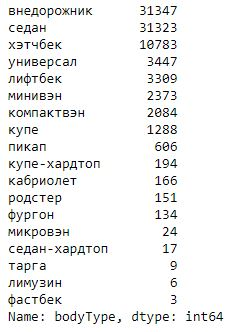

2. Признак *engineDisplacement* из категориального (текстового) был преобразован в числовой (*float64*). Использовалась следующая функция для тестового датасета:

In [196]:
def process_engineDisplacement_test(val):
    val = str(val)
    res = val.find('LTR')
    if res > 0:
        val = val[:res-1]
    if val == '':
        val = 0.0
    return val

#test['engineDisplacement'] = test['engineDisplacement'].apply(process_engineDisplacement_test)
#test['engineDisplacement'] = test['engineDisplacement'].astype(float)

Для тренировочного датасета использовалась другая функция:

In [197]:
def process_engineDisplacement_train(row):
    res = re.findall('\d\.\d', str(row['engineDisplacement']))
    if len(res) > 0:
        return float(res[0])
    else:
        res2 = re.findall('\d\.\d', str(row['name']))
        if len(res2) > 0:
            return float(res2[0])
        else:
            if row['fuelType'] == 'электро':
                return 0.0
    return None

#train['engineDisplacement'] = train.apply(process_engineDisplacement_train, axis=1)

В итоге признак *engineDisplacement* стал содержать в сводном датасете значения типа *float64* был перенесен в группу числовых признаков.

3. При обработке пропусков признака *Владельцы* было решено относить автомобили из автосалона к группе 0 (ноль) владельцев, а не 1 (один) владелец, как в исходном проекте:

In [198]:
#all_data['Владельцы'][all_data['Владельцы'].isnull()] = 0.0

При обучении выбранных моделей (CatBoost и ExtraTreesRegressor) на тренировочных данных система показала улучшение точности. При проверке на тестовых данных в Kaggle наибольшую точность показала модель ExtraTreesRegressor c параметрами по умолчанию. Итоговая точность по метрике МАРЕ в варианте №2 поднялась с 15,02% до 13,65%.

**Вывод**. В данном варианте путем изменения методики предобработки трех входных признаков, удалось поднять точность на 1,37% до уровня - 13,65%.Кроме этого было выяснено, что наилучшие результаты в тестовом датасете показывает модель ExtraTreesRegressor со значениями гиперпараметров по умолчанию, которая и стала использоваться как итоговая для улучшения точности в других версиях.

**5.4. Версия № 3**

Следующим на очереди в плане работ по улучшению точности была попытка генерации новых признаков. По ходу основного проекта было неоднократное упоминание от том, что часть не используемых в первой версии проекта признаков, могут являться основанием для формирования новых признаков. Используя эту информацию были сформированы следующие новые признаки.
1. **Бинарные**, основанные на изучении распредлелений типов кузовов автомобилей, их цвета, количества дверей, владельцев и возраста автомобиля:


In [199]:
#all_data['TopBodyType'] = all_data['bodyType'].apply(lambda x: 1 if x in ['седан', 'внедорожник'] else 0)
#all_data['RareBodyType'] = all_data['bodyType'].apply(lambda x: 1 if x in ['лимузин', 'тарга', 'фастбек'] else 0)
#all_data['TopColors'] = all_data['color'].apply(lambda x: 1 if x in ['черный', 'белый', 'серебристый', 'серый', 'синий'] else 0)
#all_data['RareColors'] = all_data['color'].apply(lambda x: 1 if x in ['жёлтый', 'розовый'] else 0)
#all_data['TopNumberOfDoors'] = all_data['numberOfDoors'].apply(lambda x: 1 if x in [5.0, 4.0] else 0)
#all_data['Oldtimer'] = all_data['productionDate'].apply(lambda x: 1 if x < 1980 else 0)
#all_data['NewAuto'] = all_data['Владельцы'].apply(lambda x: 1 if x == 0.0 else 0)

Изучение корреляции созданных признаков на целевой признак (цена), сразу же указало на то, что признаки *TopBodyType*, *RareBodyType*, *TopColors* и *RareColors* имеют ничтожно малый коэффициент корреляции. Но в данной версии их было решено не отбрасывать.

2. **Числовые**, полученные путем математических преобразований между другими числовыми признаками датасета: пробег в год, время производства модели и возраст автомобиля.

In [200]:
def mileage_in_year(row):
    if row['productionDate'] == 2020:
        return row['mileage']
    return row['mileage'] / (2020 - row['productionDate'])
    
#all_data['mileage_in_year'] = all_data.apply(mileage_in_year, axis=1)
#ll_data['time_of_production'] = all_data['productionDate'] - all_data['modelDate']
#all_data['age_auto'] = 2021 - all_data['productionDate']

При оценке значимости новых числовых переменных можно отметить следующее:
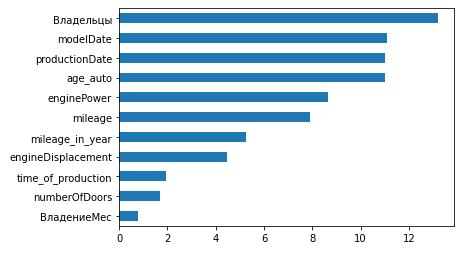
- все новые числовые признаки вляются значимыми для целевого признака и должны использоваться при обучении модели.

При проверке результатов работы модели ExtraTreesRegressor, обученной по обновленным данным, произошло увеличение точности. Лучший результат в 13,27% показала вариант модели с настройками праметров по умолчанию.

**Вывод**. Генерация новых признаков в объединенном датасете привело к увеличению точности модели на 0,38% по сравнению с предыдущим вариантом (№ 2). Получена итоговая точность - 13,27%.

**5.5. Версия № 4**

Следующей проверяемой гипотезой стала попытка "адаптации" тренировочного датасета к данным тестовой выборки. Для этого было решено сократить количество строк в тренировочной выборке для строк в которых использовались бренды (признак *brand*), которых нет в тестовой выборке. Для этого при обработке признака *brand* использовался следующий программный код:

In [201]:
#brands = test['brand'].unique().tolist()
#train = train[train['brand'].isin(brands)]

Это позволило получить в тренировочной выборке следующую модальность признака *brand*:
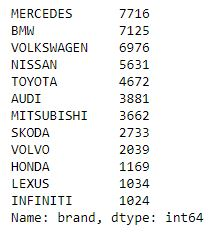

Обучение модели на уменьшенной тренировочной выборке и проверка ее работы на тестовом датасете, привело к следующему повышению точности модели - 11,90%!

**Вывод**. Не смотря на уменьшение размера обучающей выборки и большему ограничению обрабатываемых модели брендов автомобилей, с позиции точности результата в Leaderboard Kaggle, произошло скачкообразное увеличение точности по метрике MAPE до значения 11,90% (увеличение на 1,37%).

**5.6. Версия № 5**

В версии № 5 была исправлена ошибка, найденная в программном коде преобразованиях цвета в тренировочном датасете (вместо желтого цвета стоял оранжевый). Пересчет модели после изменения этих данных не превел к улучшению результата. Он даже немного ухудшился.

**Вывод**. Данная версия является сервисной и нужна была для понимания влияния ошибки первичных данных на итоговые результаты работы модели. На основании этих экспериментов были скорректированы результаты работы моделей в исходной версии проекта.

**5.7. Версия № 6**

Версия № 6 была попыткой корректировки преобразования некоторых имеющихся признаков в проекте для улучшения точности модели. К сожалению, ни один из нескольких вариантов "косметических" доработок преобразования признаков не привел к улучшению модели. Чаще всего на тренировочных данных точность возрастала, но в тестовых данных имело место небольшое ухудшение уже достигнутой ранее точности.

**Вывод**. Данная версия является не удачной и была отброшена в поседующих экспериментах. Требуются другие подходы для принципиального увеличения точности.

**5.8. Версия № 7**

В версии № 7 был произведен углубленный анализ реляционных связей в итоговом обучающем датасете. Было получено не только визуальное представление связи между всеми признаками модели:
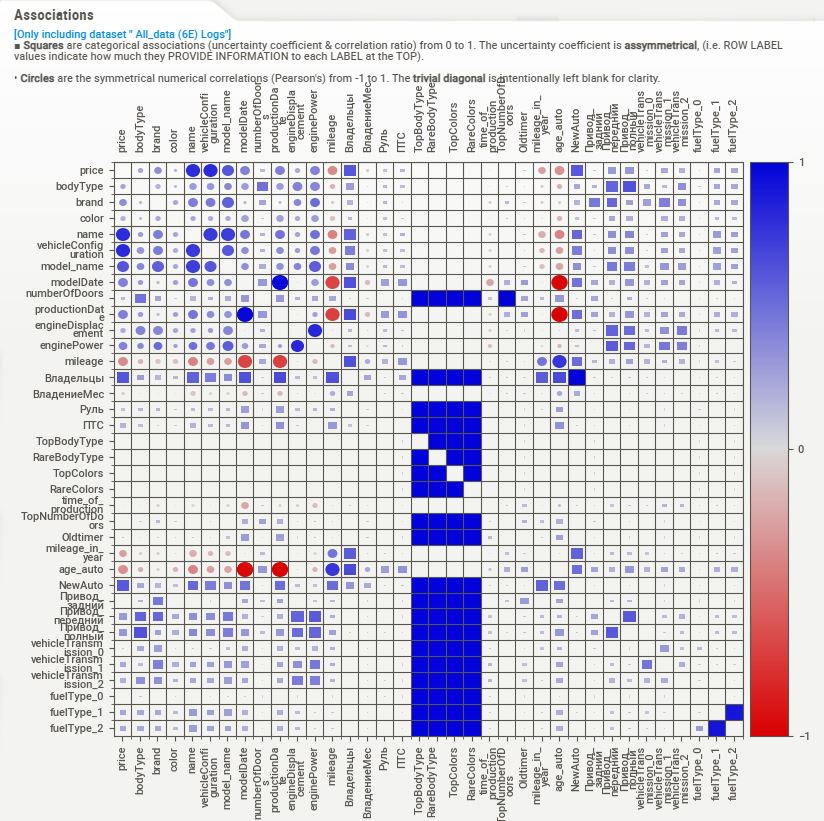
но и вычислены численные значения этой взаимосвязи:

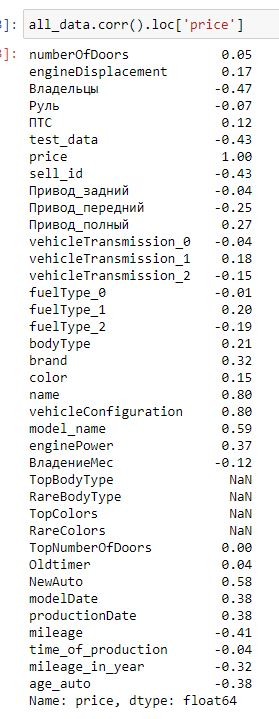
Это позволило сделать вывод о том, что часть используемых признаков можно отброить в силу либо сильной корреляции, либо наоборот - почти отсутсвующей.

Среди сильно коррелирующих признаков были отброшены *name* и *vehicleConfiguration* (К = 0,8). Среди не коррелирующих - *TopBodyType*, *RareBodyType*, *TopColors*, *RareColors* и *TopNumberOfDoors*. Видно, что среди последних, все были созданы на этапе генерации новоых признаков в версии №3.

Последующее обучение модели ExtraTreesRegressor (с параметрами по умолчанию) привело к заметному повышению точности работы модели на тестовых данных в Kaggle - на 1,2%, до значения 10,7%.

**Вывод**. Более тщательный анализ признаков с позиции корреляции позволил в очередной раз скачкообразно повысить точность модели до значения 10,7%. В перспективе, нужно более внимательно осносится к данному вопросу в процессе предобработки данных.

**5.9. Версия № 8**

В версии № 8 была произведена попытка поработать с признаком *model_name*. Предлагалось все имена моделей автомобилей из тренировочного датасета которых нет в тестовом, а так же имена из тестового, которых нет в тренировочном датасете, заменить категорией "Ohter" (Другие). Это было реализовано с помощью следующего программного кода:

In [202]:
#i1 = train['model_name'].value_counts().index
#i2 = test['model_name'].value_counts().index
#s = 0
#for i in i1:
#    flag = False
#    for j in i2:
#        if i == j:
#            flag = True
#    if flag == False:
#        rec = train[train['model_name'] == i]['model_name'].count()
#        train['model_name'] = train['model_name'].apply(lambda x: 'Other' if x == i else x)
#        print(i, 'не найден в тест', rec)
#        s +=rec
#print('---Всего в train:', s)

#s = 0
#for i in i2:
#    flag = False
#    for j in i1:
#        if i == j:
#            flag = True
#    if flag == False:
#        rec = test[test['model_name'] == i]['model_name'].count()
#        test['model_name'] = test['model_name'].apply(lambda x: 'Other' if x == i else x)
#        print(i, 'не найден в train', rec)
#        s +=rec
#print('---Всего в test:', s)

#print(len(train['model_name'].unique()))
#print(len(test['model_name'].unique()))

Это позволило получить в обоих исходных датасетах 526 категориальных значений признака *model_name*, вместо 544 - в тестовом и 554 - в тренировочном. К сожалению, даннае преобразование не привело к заметному улучшению точности работы модели. Точность практически не изменилась, даже слегка уменьшилась начиная с 3-го знака после запятой.

**Вывод**. На основании неизменных целевых результатов от данной доработки было решено отказаться.

**5.10. Версия № 9**

В версии № 9 проверялась ручная настройка гиперпараметра *n_estimators* у регрессора ExtraTreesRegressor. Опытным путем, было получено наиболее эффективное значение *n_estimators=300* для тестовой выборки в Kaggle, несмотря на то, что автоматическая система подбора гиперпараметров давала значение *n_estimators=410* и на тренировочной выборке значение точности повышалось.

Кроме этого, была проведена очередная ревизия признаков в тестовой выборке, и на основании этого в тренировочную выборку был введен новый признак *vendor*, который присутствует в тествовом датасете, но отсутствует в тренировочном. Его заполнение производилось с помощью функции:

In [203]:
def add_flag_japan(brand):
    if brand == 'NISSAN' or brand == 'TOYOTA' or brand == 'MITSUBISHI' or brand == 'HONDA' or brand == 'INFINITI' or brand == 'LEXUS':
        return 1
    else:
        return 0
    
#all_data['vendor'] = all_data['brand'].apply(add_flag_japan)

Данный признак был отнесен к бинарным и преобразован к 0 и 1.

Введение в проект двух указанных выше доработок позволило обучить модель в новых условиях и получить на тестовых данных в Kaggle точность 10,64%. Повышение на 0,07%.

**Вывод**. Не все возможные признаки были использованы в первичном проекте. Подключение новых признаков приводит к незначительному, но все же, к повышению точности модели. Так же стоит отметить, что для рассматриваемого регрессора ExtraTreesRegressor значения гиперпараметров по умолчанию, оказываются наиболее эффективными. Немного удалось повысить итоговую точность только посредством небольшого увеличения количества деревьев (*n_estimators*). Далее при повышении этого количества точность понижалась.

**5.11. Версия № 10**

В версии № 10 было решено в плотную занятся не использованным ранее описательным признаком *complectation_dict*. Детальный анализ содержимого данного признака позволил сделать вывод, что в нем в формате JSON находится список дополнительных опций автомобиля. Данный признак заполнен не во всех строках, но судя по содержимому других признаков - он преобладает у новых автомобилей продаваемых автосалонами. Зная, что в сводном датасете таких записей достатчно много, было решено использовать предложенные опции из поля *complectation_dict* в качестве дополнительных бинарных полей в исследуемом датасете.

Для реализации этой задачи пришлось создать несколько функций, которые позволяют корректно обработать признак *complectation_dict*. Во первых, это функция выделения из исходного признака нужного нам списка опций, т.к. зачастую в признаке также содержится и другая служебная информация автосалонов.

In [204]:
def cut_string_cfg(cfg):
    empty_str = '{"id":"0","name":"","available_options":[]}'
    beg = cfg.find('{"id":')
    if len(cfg) == 0:
        return empty_str
    elif beg == -1:
        return empty_str
    else:
        if cfg.find('"available_options":[') == -1:
            return empty_str
        else:
            end = cfg.find(']')
            return cfg[beg:end+1] + '}'
    
#test['complectation_dict_mod'] = test['complectation_dict'].apply(cut_string_cfg)

Т.к. в тренировочном датасете данные были немного в другом формате, то для него использовался второй вариант этой функции:

In [205]:
def cut_string_cfg2(cfg):
    empty_str = '{"id":"0","name":"","available_options":[]}'
    beg = cfg.find("{'id':")
    if len(cfg) == 0:
        return empty_str
    elif beg == -1:
        return empty_str
    else:
        if cfg.find("'available_options':") == -1:
            return empty_str
        else:
            end = cfg.find(']')
            return cfg[beg:end+1] + '}'
        
#train['complectation_dict_mod'] = train['complectation_dict'].apply(cut_string_cfg2)

Далее, после объединения датасета и определения всего доступного списка дополнительных опций автомбиля, создаем их в качестве колонок в объединеном датасете:

In [206]:
available_options = ['adj-pedals',
 'driver-seat-electric',
 'rear-seats-heat',
 'navigation',
 'alcantara',
 'apple-carplay',
 'electro-mirrors',
 'massage-seats',
 'start-button',
 '17-inch-wheels',
 '12v-socket',
 'high-beam-assist',
 'leather-gear-stick',
 'climate-control-1',
 'dual-xenon',
 'entertainment-system-for-rear-seat-passengers',
 'front-seat-support',
 'esp',
 'audiosystem-cd',
 'air-suspension',
 'park-assist-r',
 'paint-metallic',
 'wheel-memory',
 'decorative-interior-lighting',
 '14-inch-wheels',
 '21-inch-wheels',
 'wheel-power',
 'dha',
 'drowsy-driver-alert-system',
 'ya-auto',
 '20-inch-wheels',
 'mirrors-heat',
 'night-vision',
 'electro-window-back',
 'multizone-climate-control',
 'usb',
 'isofix-front',
 'steering-wheel-gear-shift-paddles',
 'keyless-entry',
 'multi-wheel',
 'bas',
 'fabric-seats',
 'activ-suspension',
 'audiosystem-tv',
 'aux',
 'lock',
 'automatic-lighting-control',
 'glonass',
 'light-sensor',
 'rain-sensor',
 'front-seats-heat',
 'airbag-curtain',
 'passenger-seat-updown',
 'black-roof',
 'led-lights',
 'folding-front-passenger-seat',
 'tinted-glass',
 'e-adjustment-wheel',
 'spare-wheel',
 'easy-trunk-opening',
 'light-cleaner',
 'computer',
 'rear-camera',
 'electro-window-front',
 '19-inch-wheels',
 'sport-seats',
 'wheel-configuration1',
 'lane-keeping-assist',
 'wireless-charger',
 'hatch',
 'front-seats-heat-vent',
 'front-camera',
 'climate-control-2',
 'knee-airbag',
 'blind-spot',
 'reduce-spare-wheel',
 'ashtray-and-cigarette-lighter',
 'combo-interior',
 'isofix',
 'programmed-block-heater',
 'servo',
 'wheel-leather',
 'steel-wheels',
 'airbag-passenger',
 'rear-seat-heat-vent',
 'third-row-seats',
 'heated-wash-system',
 'windscreen-heat',
 'auto-cruise',
 'electro-trunk',
 'xenon',
 'leather',
 'park-assist-f',
 'cooling-box',
 'electronic-gage-panel',
 'projection-display',
 'voice-recognition',
 'cruise-control',
 'laminated-safety-glass',
 'wheel-configuration2',
 'remote-engine-start',
 'alarm',
 'bluetooth',
 'traffic-sign-recognition',
 'driver-seat-support',
 'airbag-driver',
 'sport-suspension',
 'seat-transformation',
 '22-inch-wheels',
 'condition',
 'passenger-seat-electric',
 'drl',
 'roller-blind-for-rear-window',
 'abs',
 '18-inch-wheels',
 'airbag-rear-side',
 'driver-seat-memory',
 'wheel-heat',
 'drive-mode-sys',
 'laser-lights',
 'volume-sensor',
 'feedback-alarm',
 'asr',
 'door-sill-panel',
 'sport-pedals',
 'body-kit',
 'hcc',
 'immo',
 'android-auto',
 'auto-mirrors',
 'audiopreparation',
 'power-child-locks-rear-doors',
 'roller-blinds-for-rear-side-windows',
 'adaptive-light',
 'start-stop-function',
 '360-camera',
 '15-inch-wheels',
 'power-latching-doors',
 'front-centre-armrest',
 'music-super',
 'roof-rails',
 'driver-seat-updown',
 'electro-rear-seat',
 'vsm',
 'eco-leather',
 'windcleaner-heat',
 '220v-socket',
 '16-inch-wheels',
 'airbag-side',
 'rear-seat-memory',
 'panorama-roof',
 'ptf',
 'seat-memory',
 'folding-tables-rear',
 'auto-park',
 'tyre-pressure',
 'body-mouldings',
 'third-rear-headrest',
 'collision-prevention-assist']

#for i in range(40, 40+len(available_options)):
#    all_data.insert(i, available_options[40-i], 0)

Таких новых колонок получется 159 шт.(!) При создании новых колонок сразу же заполняем в строках по ним значение 0 (ноль). Далее производим заполненение этих колонок-признаков по строкам, в зависимости от наличия соответсвующей опции в полученном ранее признаке *complectation_dict_mod*:

In [207]:
#from tqdm import tqdm

#err = []
#for i in tqdm(all_data.index):
#    s = all_data['complectation_dict_mod'].loc[i].replace("'", '"')
#    s = s.replace("\'", '"')
#    s = s.replace('"БИ2"', "'БИ2'")
#    s = s.replace('"PROSAFETY"', "'PROSAFETY'")
#    s = s.replace('"WaY"', "'WaY'")
#    s = s.replace('"Теплые опции"', "'Теплые опции'")
#    s = s.replace('"17"', '`17"')
#    try:
#        df = pd.read_json(s)
#        #print(df,s)
#        for j in df.index:
#            cur_option = df['available_options'].loc[j]
#            all_data[cur_option].loc[i] = 1
#            #print(cur_option)
#    except ValueError:
#        err.append(i)

Замечания по последнему программному коду. 1) Т.к. процесс заполнения получается долговременный (у меня на это занимало порядка 25 мин.), то в программый код введен индикатор прогресса из библиотеки *tqdm*. 2) По ходу обработки данных из признака *complectation_dict_mod* было обнаружено несколько проблем с использованием разделителей ' и " в JSON, которые потребовали вводить исключения по определенным подстрокам (см. в программном коде).

После заполнения данных был проведен корреляционный анализ, на основании котрого около 10 опций были удалены из данных, т.к. практически не оказывали вляния на целевой признак. В итоге получили датасет со 185 колонками, большенство которых составляют бинарные опции автомобиля.

На полученном в результате данной обработке датасете обучили модель и при проверке точности в Kaggle получили повышенную точность на уровне 10,51% (повышение по сравнению с прошлым результатом 0,13%).

**Вывод**. Используя ранее отброшенный описательный признак *complectation_dict* удалось еще немного поднять точность модели.

**5.12. Выводы по разделу**
1. Удалось провысить точность полученной в проекте модели по метрике MAPE со значения 15,02% до значения 10,51%, т.е. более чем на 4,5%.
2. В Leaderboard Kaggle удалось переместиться с 123 места изначально (исходная версия проекта) до 14 места (версия 10) из 319 участников соревнования по данной теме.
3. Для улучшения точности модели использованы методы доработки и переработки исходных признаков данных, генерации новых признаков, углубленный корреляционный анализ, балансировка значений в обучающей и тестовых выборках, а также автоматический и ручной подбор гиперпараметров модели.

**Выводы по проекту**

При работе над проектом выполнены следующие работы:
1. Произведен анализ поставленной задачи и сформирован план работ по проекту. Данный план по ходу исполнения проекта преобразовался в содержание данного проекта.
2. Произведен первичный анализ предложенных входных (тестовых) и выходных (submission) данных.
3. Произведен анализ источников получения данных для обучения ML-моделей и получен тренировочный датасет.
4. Произведен анализ и преобразование признаков тренировочного датасета для последующего объединения с тестовым датасетом.
5. Произведено объединение тренировочного и тестового датасета, а также последующая предобработка объединенного датасета для использования в ML-моделях.
6. На этапе моделирования произведен выбор лучших для нашего случая моделей и проанализирована работа шести моделей на обработанных ранее денных.
7. Выбрана модель, которая обеспечивает лучшую точность на предложенных тестовых данных.
8. По результатам выбора лучшей модели, произведено улучшение результата ее работы, для выставления этих данных на соревновании Kaggle.

Итогом выполнеия данного проекта является:
- выбор в качестве лучшей ML-модели - ExtraTreesRegressor;
- получение наилучшей достигнутой точности по метрике MAPE - 10,51%;
- занятие на 31.05.2022 г. 14 места на курсовом соревновании Kaggle по данному проекту. 